## 1. Install packages, GPU and Seed   

In [1]:
# Standard Libraries
import h5py
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToPILImage, ToTensor, RandomHorizontalFlip, RandomApply, GaussianBlur, ColorJitter
from torchvision.transforms.functional import affine, adjust_brightness, adjust_contrast, adjust_saturation
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.metrics import confusion_matrix

# Custom
from cust_functions.processing_helper import *
from cust_functions.models import *
from cust_functions.training_helper import *
from cust_functions.datavis_helper import *

In [2]:
print("Torch CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Torch CUDA available: True
Number of GPUs: 2
Current GPU: 0
GPU Name: NVIDIA GeForce GTX 1080 Ti


In [3]:
"""
Define seed
"""

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2. Data Analysis

### 2.1 Inspect the image labels visually

In [4]:
base_path = "/home/pf/pfstud/mlarriere/not_aligned_data"
h5_files = [f"{base_path}/tile_{i}_cloudfree.h5" for i in [0, 1, 3, 4]]
blt_files = [f"{base_path}/tile_{i}_BLT.h5" for i in [0, 1, 3, 4]]

In [ ]:
# Plot all h5 files with their BLT files
for h5_file, blt_file in zip(h5_files, blt_files):
    with h5py.File(h5_file, 'r') as f, h5py.File(blt_file, 'r') as blt_f:
        rgb = f['RGB_cloudfree_averaged'][:]
        nir = f['NIR_cloudfree_averaged'][:]
        blt = blt_f['BLT'][:]

        plot_with_overlays(rgb, blt)

In [ ]:
dataset = Smoothed_H5Dataset(h5_files, blt_files, patch_size=(256, 256), relevant_threshold=0.3, return_rgb_nir_separately=True)

for i in [1, 10, 20, 50, 170]:
    rgb = dataset[i][0].permute(1, 2, 0).numpy()
    truth = dataset[i][2].squeeze(0).cpu().numpy()
    plot_with_overlays(rgb, truth)

### 2.1 Inspect the data numerically

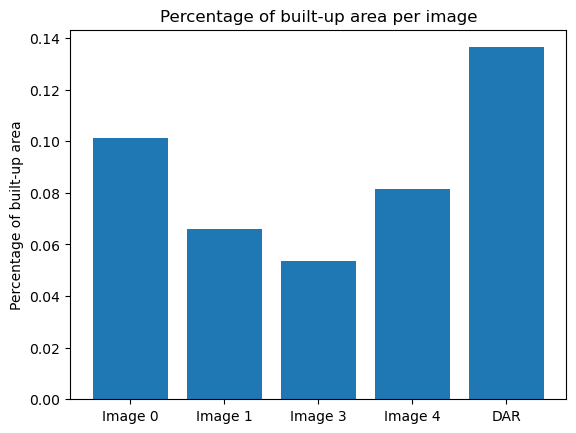

In [6]:
# Get distribution of BLT percentage per image

base_path = "/home/pf/pfstud/mlarriere/not_aligned_data"
h5_files = [f"{base_path}/tile_{i}_cloudfree.h5" for i in [0, 1, 3, 4]] + ["/home/pf/pfstud/mlarriere/not_aligned_data/DAR_cloudfree.h5"]
blt_files = [f"{base_path}/tile_{i}_BLT.h5" for i in [0, 1, 3, 4]] + ["/home/pf/pfstud/mlarriere/not_aligned_data/DAR_BLT.h5"]

percentages = []
built_up_areas = []
other_areas = []
for h5_file, blt_file in zip(h5_files, blt_files):
    with h5py.File(h5_file, 'r') as f, h5py.File(blt_file, 'r') as blt_f:
        blt = blt_f['BLT'][:]
        # check for 99 values and replace with 0
        blt[blt == 99] = 0
        built_up_areas.append(blt.sum())
        other_areas.append((blt.shape[0] * blt.shape[1]) - blt.sum())
        perc = blt.sum() / (blt.shape[0] * blt.shape[1])
        percentages.append(perc)
        
#total_perc = sum(built_up_areas) / (sum(built_up_areas) + sum(other_areas))
#percentages.append(total_perc)

# show results in bar plot including total percentage of built-up area
plt.bar(range(len(percentages)), percentages)
plt.ylabel("Percentage of built-up area")
plt.title("Percentage of built-up area per image")
plt.xticks(range(len(percentages)), ["Image 0", "Image 1", "Image 3", "Image 4", "DAR"])
plt.show()


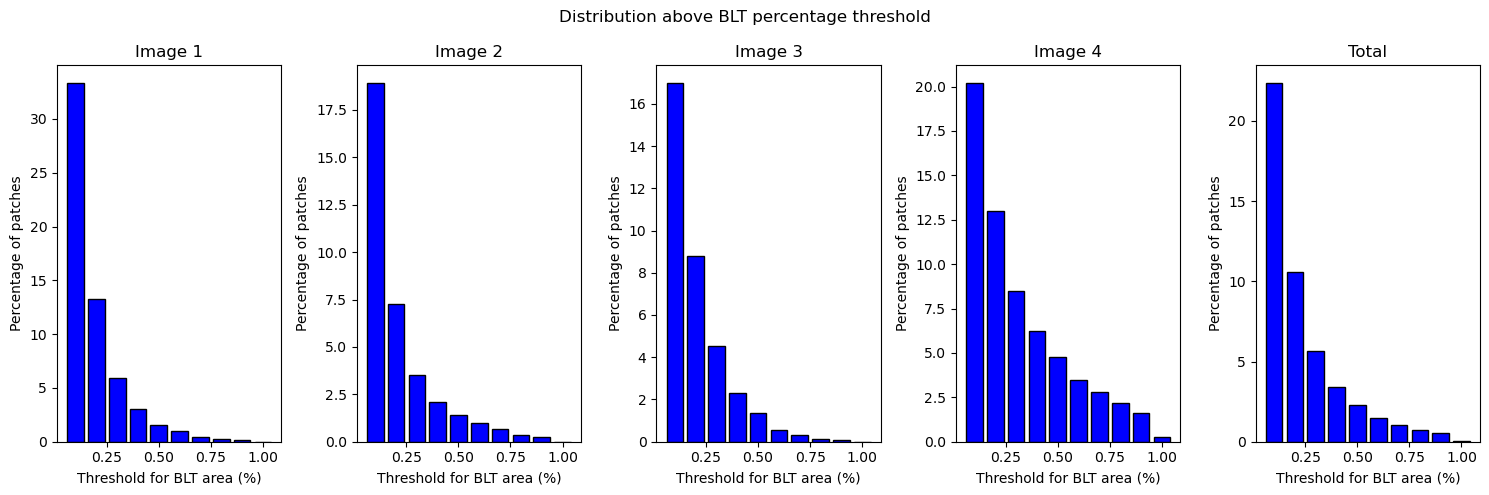

In [6]:
# Plot distribution of patches over BLT percentage thresholds per image and total
thresholds = np.arange(0.1, 1.1, 0.1)
plot_patch_distribution_per_image(h5_files, blt_files, patch_size=(128, 128), thresholds=thresholds)

In [141]:
threshold = 0.0 # minimum percentage BLT in patch
dataset = Smoothed_H5Dataset(h5_files, blt_files, patch_size=(128, 128), relevant_threshold=threshold, return_rgb_nir_separately=False)

# Split dataset into train and validation set (80/20)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# show distribution of built-up area in train and validation set
train_built_up_area = sum([dataset[i][1].sum() for i in train_dataset.indices])
val_built_up_area = sum([dataset[i][1].sum() for i in val_dataset.indices])

train_total_area = sum([dataset[i][1].shape[0] * dataset[i][1].shape[1] for i in train_dataset.indices])
val_total_area = sum([dataset[i][1].shape[0] * dataset[i][1].shape[1] for i in val_dataset.indices])

train_perc = train_built_up_area / train_total_area
val_perc = val_built_up_area / val_total_area

print(f"Train percentage of built-up area: {train_perc}")
print(f"Validation percentage of built-up area: {val_perc}")

Train percentage of built-up area: 9.511009216308594
Validation percentage of built-up area: 10.410892486572266


## 4. Model pipelines

### 4.1 Model 1: Simple DNN model (baseline) 

In [15]:
# Create dataset and dataloaders

base_path = "/home/pf/pfstud/mlarriere/not_aligned_data"
h5_files = [f"{base_path}/tile_{i}_cloudfree.h5" for i in [0, 1, 3, 4]]
blt_files = [f"{base_path}/tile_{i}_BLT.h5" for i in [0, 1, 3, 4]]

threshold = 0.0 # minimum percentage BLT in patch
dataset = Smoothed_H5Dataset(h5_files, blt_files, patch_size=(128, 128), relevant_threshold=threshold, return_rgb_nir_separately=False)

# Split dataset into train and validation set (80/20)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [18]:
# Define model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CHANNELS = 4
NUM_CLASSES = 2

num_epochs = 5
lr = 0.001
weight_decay = 1e-5
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
model = BaselineModel(NUM_CHANNELS, NUM_CLASSES)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


train_results = {
    "train_loss": [],
    "train_accuracy": [],
    "train_precision": [],
    "train_recall": [],
    "train_f1_score": []
}

val_results = {
    "val_loss": [],
    "val_accuracy": [],
    "val_precision": [],
    "val_recall": [],
    "val_f1_score": []
}

best_val_loss = np.inf
best_model = None
patience = 10


# Train model
for epoch in range(num_epochs):
    
    # train model
    running_loss, running_confusion_matrix = train_model(model, optimizer, criterion, train_dataloader, device, NUM_CLASSES, model_type='DNN')

    # Validate model
    running_val_loss, running_val_confusion_matrix = validate_model(model, criterion, val_dataloader, device, NUM_CLASSES, model_type='DNN')

    # Early stopping
    if running_val_loss < best_val_loss:
        best_val_loss = running_val_loss
        best_model = model.state_dict().copy()
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

    # Calculate epoch metrics
    epoch_train_loss = running_loss / len(train_dataloader)
    epoch_train_accuracy = running_confusion_matrix.trace() / running_confusion_matrix.sum()
    epoch_recall = running_confusion_matrix[1, 1] / (running_confusion_matrix[1, 1] + running_confusion_matrix[0, 1] + 1e-5)
    epoch_precision = running_confusion_matrix[1, 1] / (running_confusion_matrix[1, 1] + running_confusion_matrix[1, 0] + 1e-5)
    epoch_f1_score = 2 * (epoch_precision * epoch_recall) / (epoch_precision + epoch_recall + 1e-5)

    epoch_val_loss = running_val_loss / len(val_dataloader)
    epoch_val_accuracy = running_val_confusion_matrix.trace() / running_val_confusion_matrix.sum()
    epoch_val_recall = running_val_confusion_matrix[1, 1] / (running_val_confusion_matrix[1, 1] + running_val_confusion_matrix[0, 1] + 1e-5)
    epoch_val_precision = running_val_confusion_matrix[1, 1] / (running_val_confusion_matrix[1, 1] + running_val_confusion_matrix[1, 0] + 1e-5)
    epoch_val_f1_score = 2 * (epoch_val_precision * epoch_val_recall) / (epoch_val_precision + epoch_val_recall + 1e-5)

    # Udpate results dictionary
    train_results["train_loss"].append(epoch_train_loss)
    train_results["train_accuracy"].append(epoch_train_accuracy)
    train_results["train_precision"].append(epoch_precision)
    train_results["train_recall"].append(epoch_recall)
    train_results["train_f1_score"].append(epoch_f1_score)

    val_results["val_loss"].append(epoch_val_loss)
    val_results["val_accuracy"].append(epoch_val_accuracy)
    val_results["val_precision"].append(epoch_val_precision)
    val_results["val_recall"].append(epoch_val_recall)
    val_results["val_f1_score"].append(epoch_val_f1_score)

    print(f"Epoch {epoch+1} train loss: {epoch_train_loss:.4f}, validation loss: {epoch_val_loss:.4f}, validation f1 score: {epoch_val_f1_score:.4f}, accuracy: {epoch_val_accuracy:.4f}, precision: {epoch_val_precision:.4f}, recall: {epoch_val_recall:.4f}")


PATH = f"DNN_baseline.pth"
torch.save(best_model, PATH)

Epoch 1 train loss: 0.3866, validation loss: 0.2996, validation f1 score: 0.0000, accuracy: 0.9264, precision: 0.0000, recall: 0.0000
Epoch 2 train loss: 0.2909, validation loss: 0.2758, validation f1 score: 0.0000, accuracy: 0.9264, precision: 0.0000, recall: 0.0000
Epoch 3 train loss: 0.2745, validation loss: 0.2648, validation f1 score: 0.0000, accuracy: 0.9264, precision: 0.0000, recall: 0.0000
Epoch 4 train loss: 0.2673, validation loss: 0.2609, validation f1 score: 0.0000, accuracy: 0.9264, precision: 0.0000, recall: 0.0000
Epoch 5 train loss: 0.2650, validation loss: 0.2598, validation f1 score: 0.0000, accuracy: 0.9264, precision: 0.0000, recall: 0.0000


In [ ]:
plot_metrics(train_results, val_results)
plot_conf_matrix(running_val_confusion_matrix)

### 4.2 Model 2: Simple CNN model

In [6]:
threshold = 0.0 # minimum percentage BLT in patch
dataset = Smoothed_H5Dataset(h5_files, blt_files, patch_size=(128, 128), relevant_threshold=threshold, return_rgb_nir_separately=False)

# Split dataset into train and validation set (80/20)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [ ]:
# Define model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CHANNELS = 4
NUM_CLASSES = 2

num_epochs = 50
lr = 0.002
weight_decay = 1e-5
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
model = SimpleCNN(NUM_CHANNELS, NUM_CLASSES)
model.to(device)
model = nn.DataParallel(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5)


train_results = {
    "train_loss": [],
    "train_accuracy": [],
    "train_precision": [],
    "train_recall": [],
    "train_f1_score": []
}

val_results = {
    "val_loss": [],
    "val_accuracy": [],
    "val_precision": [],
    "val_recall": [],
    "val_f1_score": []
}

best_val_loss = np.inf
best_model = None
patience = 10


# Train model
for epoch in range(num_epochs):
    
    # train model
    running_loss, running_confusion_matrix = train_model(model, optimizer, criterion, train_dataloader, device, NUM_CLASSES, model_type='CNN')

    # Validate model
    running_val_loss, running_val_confusion_matrix = validate_model(model, criterion, val_dataloader, device, NUM_CLASSES, model_type='CNN')

     # Early stopping
    if running_val_loss < best_val_loss:
        best_val_loss = running_val_loss
        best_model = model.state_dict().copy()
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

    # Calculate epoch metrics
    epoch_train_loss = running_loss / len(train_dataloader)
    epoch_train_accuracy = running_confusion_matrix.trace() / running_confusion_matrix.sum()
    epoch_recall = running_confusion_matrix[1, 1] / (running_confusion_matrix[1, 1] + running_confusion_matrix[0, 1] + 1e-5)
    epoch_precision = running_confusion_matrix[1, 1] / (running_confusion_matrix[1, 1] + running_confusion_matrix[1, 0] + 1e-5)
    epoch_f1_score = 2 * (epoch_precision * epoch_recall) / (epoch_precision + epoch_recall + 1e-5)

    epoch_val_loss = running_val_loss / len(val_dataloader)
    epoch_val_accuracy = running_val_confusion_matrix.trace() / running_val_confusion_matrix.sum()
    epoch_val_recall = running_val_confusion_matrix[1, 1] / (running_val_confusion_matrix[1, 1] + running_val_confusion_matrix[0, 1] + 1e-5)
    epoch_val_precision = running_val_confusion_matrix[1, 1] / (running_val_confusion_matrix[1, 1] + running_val_confusion_matrix[1, 0] + 1e-5)
    epoch_val_f1_score = 2 * (epoch_val_precision * epoch_val_recall) / (epoch_val_precision + epoch_val_recall + 1e-5)

    # Udpate results dictionary
    train_results["train_loss"].append(epoch_train_loss)
    train_results["train_accuracy"].append(epoch_train_accuracy)
    train_results["train_precision"].append(epoch_precision)
    train_results["train_recall"].append(epoch_recall)
    train_results["train_f1_score"].append(epoch_f1_score)

    val_results["val_loss"].append(epoch_val_loss)
    val_results["val_accuracy"].append(epoch_val_accuracy)
    val_results["val_precision"].append(epoch_val_precision)
    val_results["val_recall"].append(epoch_val_recall)
    val_results["val_f1_score"].append(epoch_val_f1_score)

    print(f"Epoch {epoch+1} train loss: {epoch_train_loss:.4f}, validation loss: {epoch_val_loss:.4f}, f1 score: {epoch_val_f1_score:.4f}, accuracy: {epoch_val_accuracy:.4f}, precision: {epoch_val_precision:.4f}, recall: {epoch_val_recall:.4f}")
    
    # Update learning rate
    scheduler.step(epoch_val_loss)

# Save model
saved_f1 = np.round(val_results["val_f1_score"][np.argmin(val_results["val_loss"])], 2)
PATH = f"SimpleCNN_bestf1_{saved_f1}.pth"
torch.save(best_model, PATH)

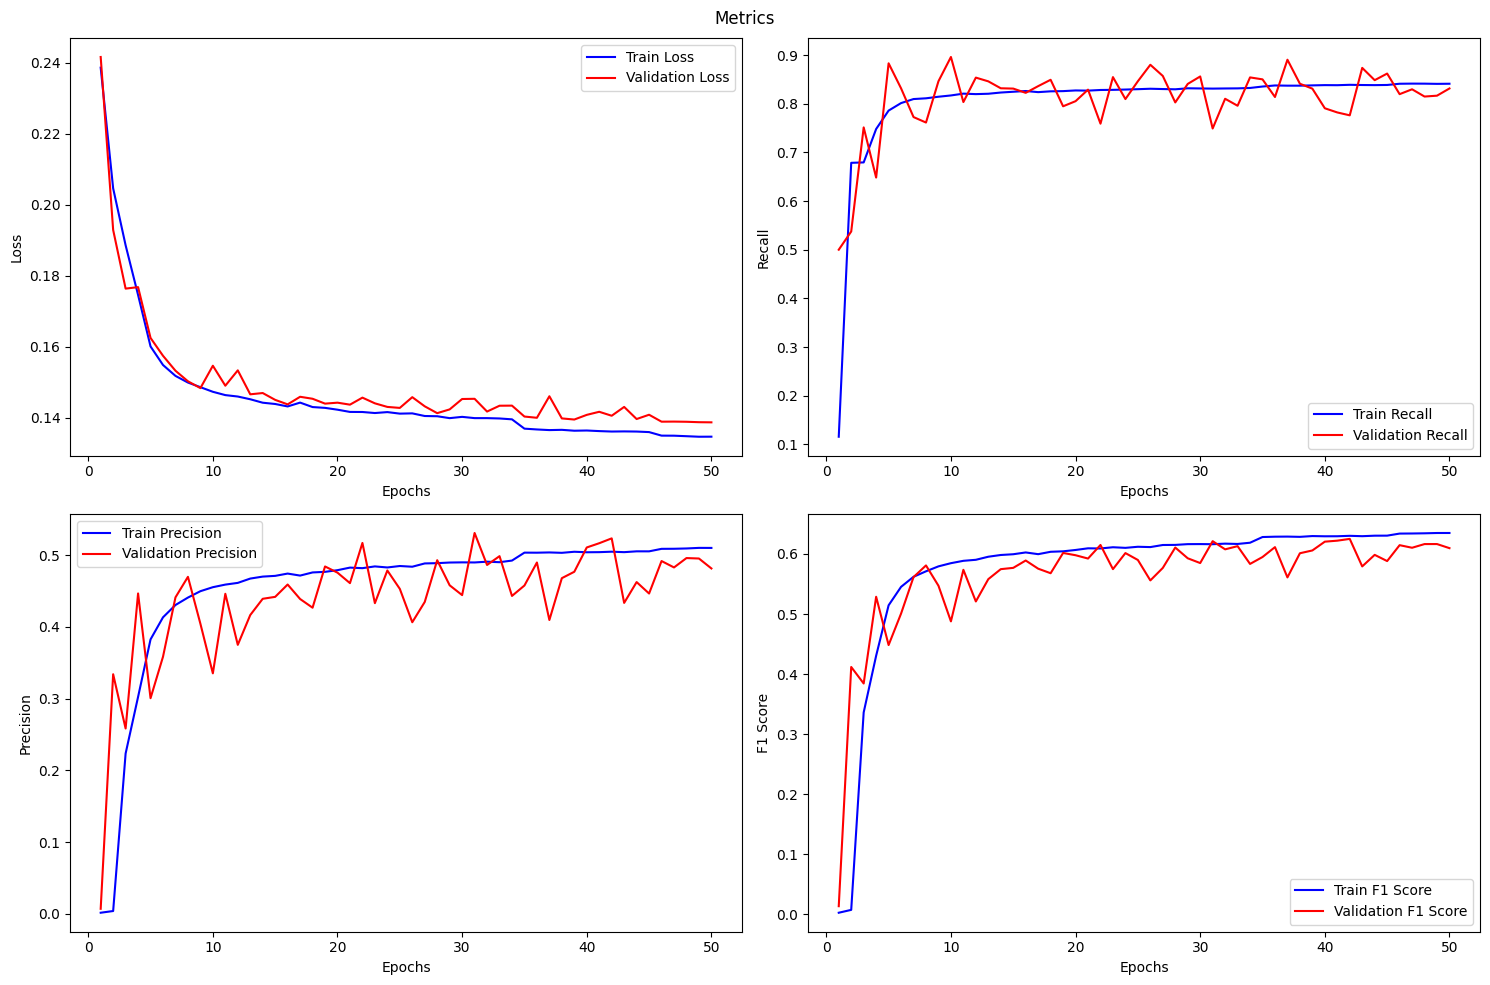

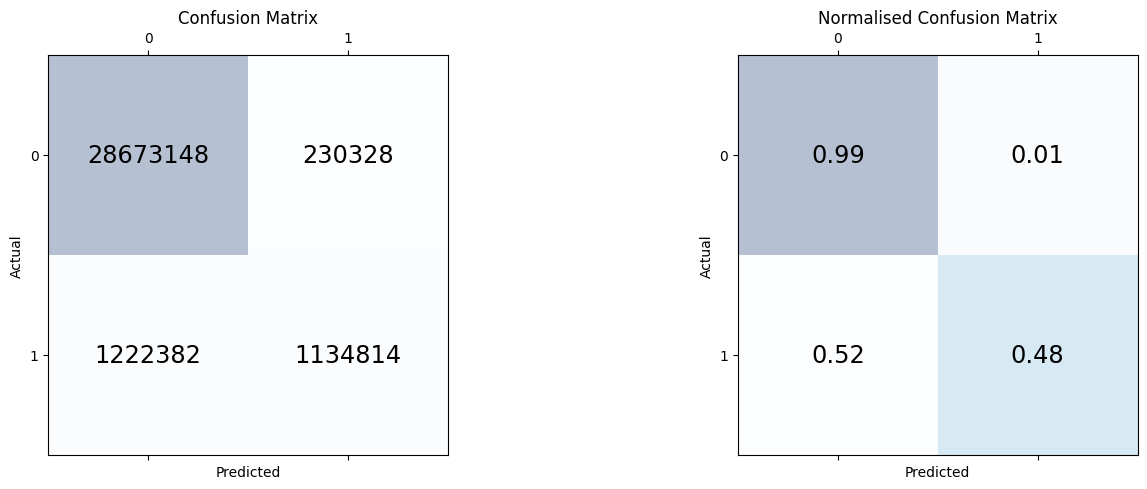

Best epoch: 50
Best validation loss: 0.1387
Best validation accuracy: 0.9535
Best validation precision: 0.4814
Best validation recall: 0.8313
Best validation f1 score: 0.6097


In [49]:
plot_metrics(train_results, val_results)
plot_conf_matrix(running_val_confusion_matrix)

# Print best model metrics
best_epoch = np.argmin(val_results["val_loss"])
print(f"Best epoch: {best_epoch+1}")
print(f"Best validation loss: {val_results['val_loss'][best_epoch]:.4f}")
print(f"Best validation accuracy: {val_results['val_accuracy'][best_epoch]:.4f}")
print(f"Best validation precision: {val_results['val_precision'][best_epoch]:.4f}")
print(f"Best validation recall: {val_results['val_recall'][best_epoch]:.4f}")
print(f"Best validation f1 score: {val_results['val_f1_score'][best_epoch]:.4f}")

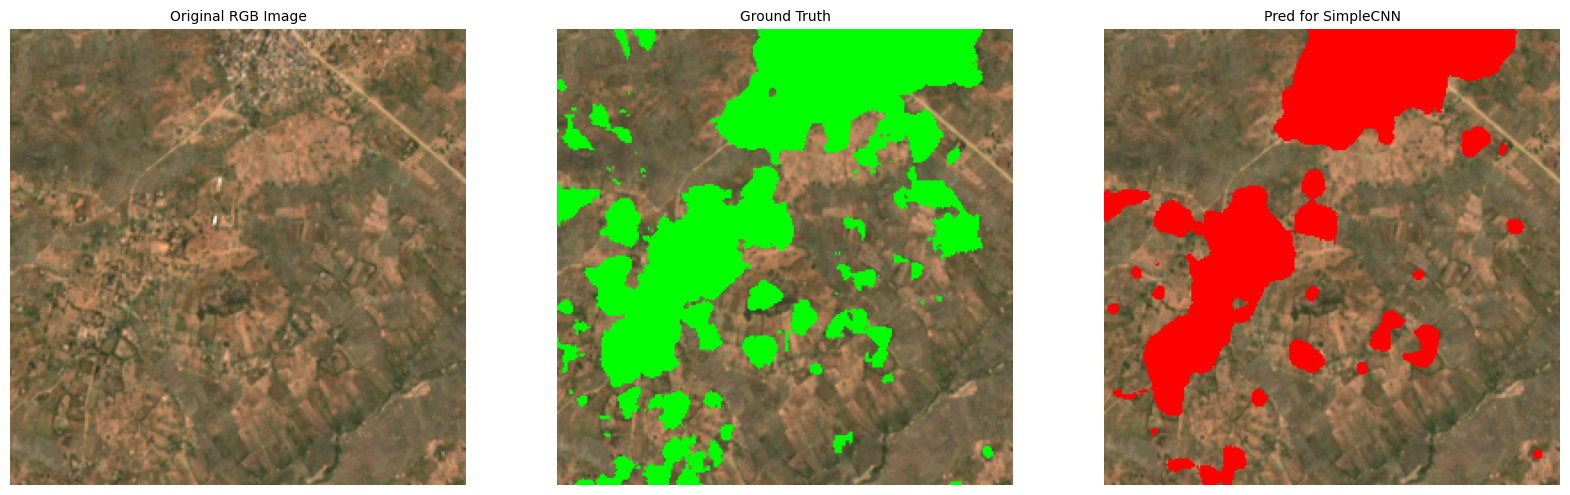

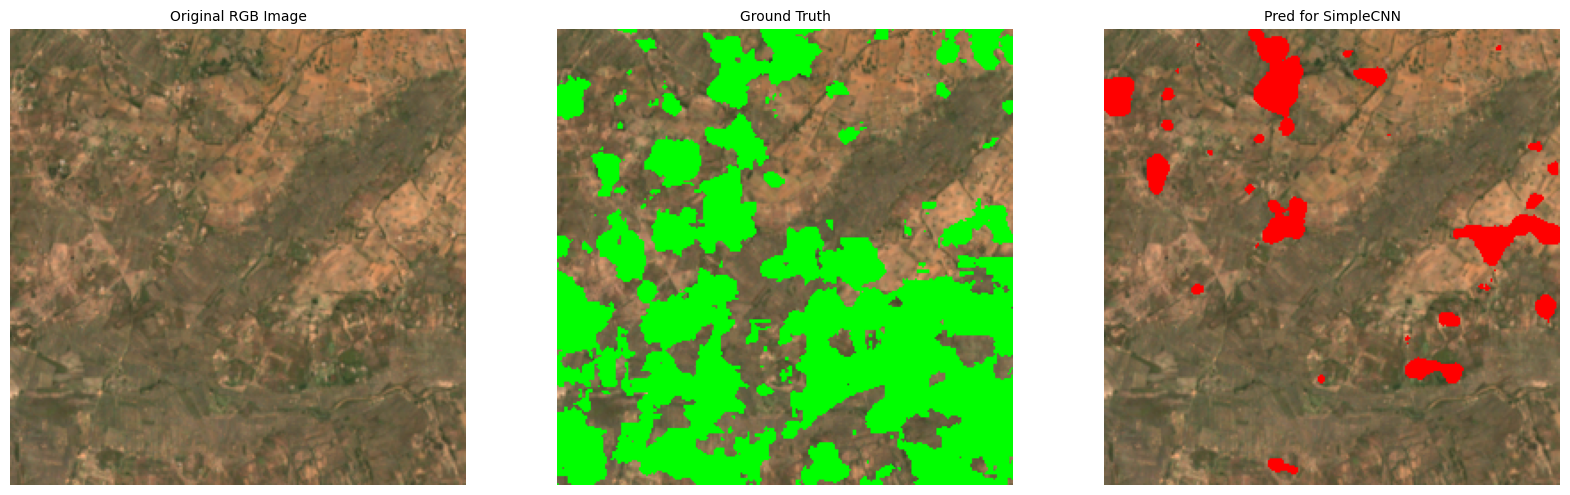

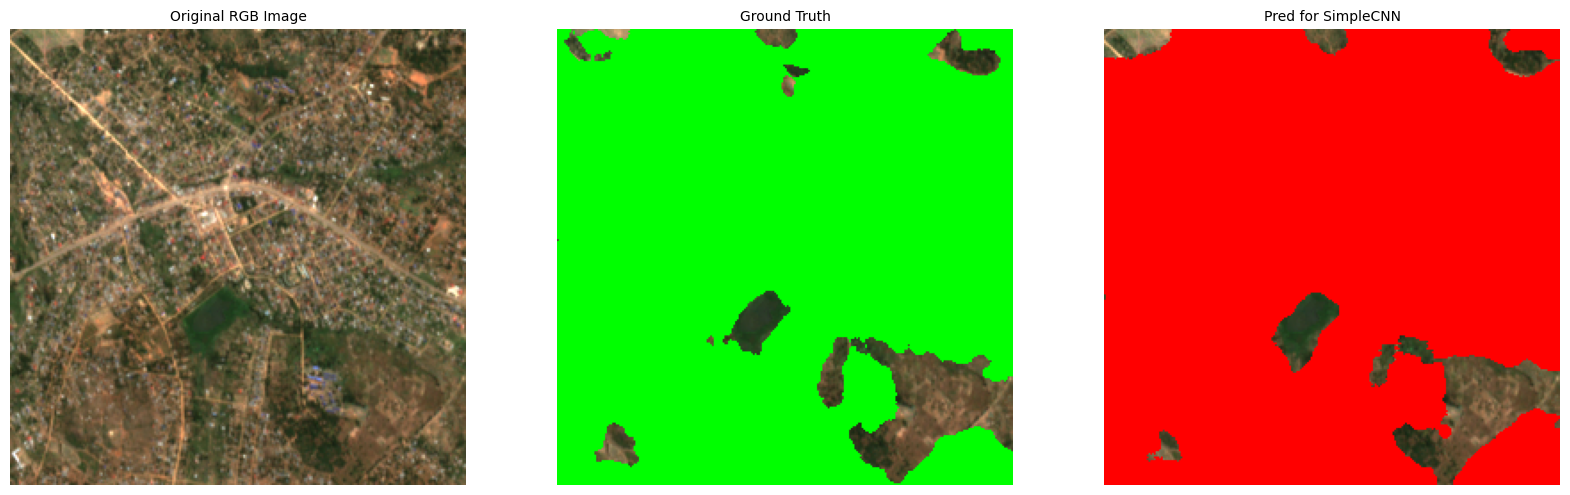

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CHANNELS = 4
NUM_CLASSES = 2
PATH = "saved_models/SimpleCNN_bestf1_061.pth"
#simplecnn = SimpleCNN(NUM_CHANNELS, NUM_CLASSES)
model = load_model(SimpleCNN, PATH, device, NUM_CHANNELS, NUM_CLASSES)

# Get dataset
dataset_seperated = Smoothed_H5Dataset(h5_files, blt_files, patch_size=(256, 256), relevant_threshold=0.3, return_rgb_nir_separately=True)
dataset_for_prediction = Smoothed_H5Dataset(h5_files, blt_files, patch_size=(256, 256), relevant_threshold=0.3, return_rgb_nir_separately=False)

# Plot prediction and ground truth overlayed on rgb image
for i in [1, 10, 170]:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()
    pred = predict_on_patch(model, dataset_for_prediction, i, device)
    truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()
    plot_with_overlays(rgb, truth, predictions=[pred], model_names = ['SimpleCNN'])



### 4.3 Simple CNN with weight adjustments for class imbalance

cuda


Epoch 1 train loss: 0.3047, validation loss: 0.2925, f1 score: 0.0141, accuracy: 0.9265, precision: 0.0071, recall: 0.5000
Epoch 6 train loss: 0.2017, validation loss: 0.1892, f1 score: 0.5695, accuracy: 0.9488, precision: 0.4606, recall: 0.7456
Epoch 11 train loss: 0.1879, validation loss: 0.1817, f1 score: 0.5905, accuracy: 0.9524, precision: 0.4671, recall: 0.8026
Epoch 16 train loss: 0.1835, validation loss: 0.1789, f1 score: 0.6141, accuracy: 0.9539, precision: 0.4991, recall: 0.7979
Epoch 21 train loss: 0.1818, validation loss: 0.1781, f1 score: 0.6035, accuracy: 0.9543, precision: 0.4735, recall: 0.8319
Epoch 26 train loss: 0.1807, validation loss: 0.1759, f1 score: 0.6349, accuracy: 0.9521, precision: 0.5668, recall: 0.7216
Epoch 31 train loss: 0.1759, validation loss: 0.1717, f1 score: 0.6403, accuracy: 0.9531, precision: 0.5674, recall: 0.7346
Epoch 36 train loss: 0.1755, validation loss: 0.1704, f1 score: 0.6318, accuracy: 0.9550, precision: 0.5254, recall: 0.7921
Epoch 41 t

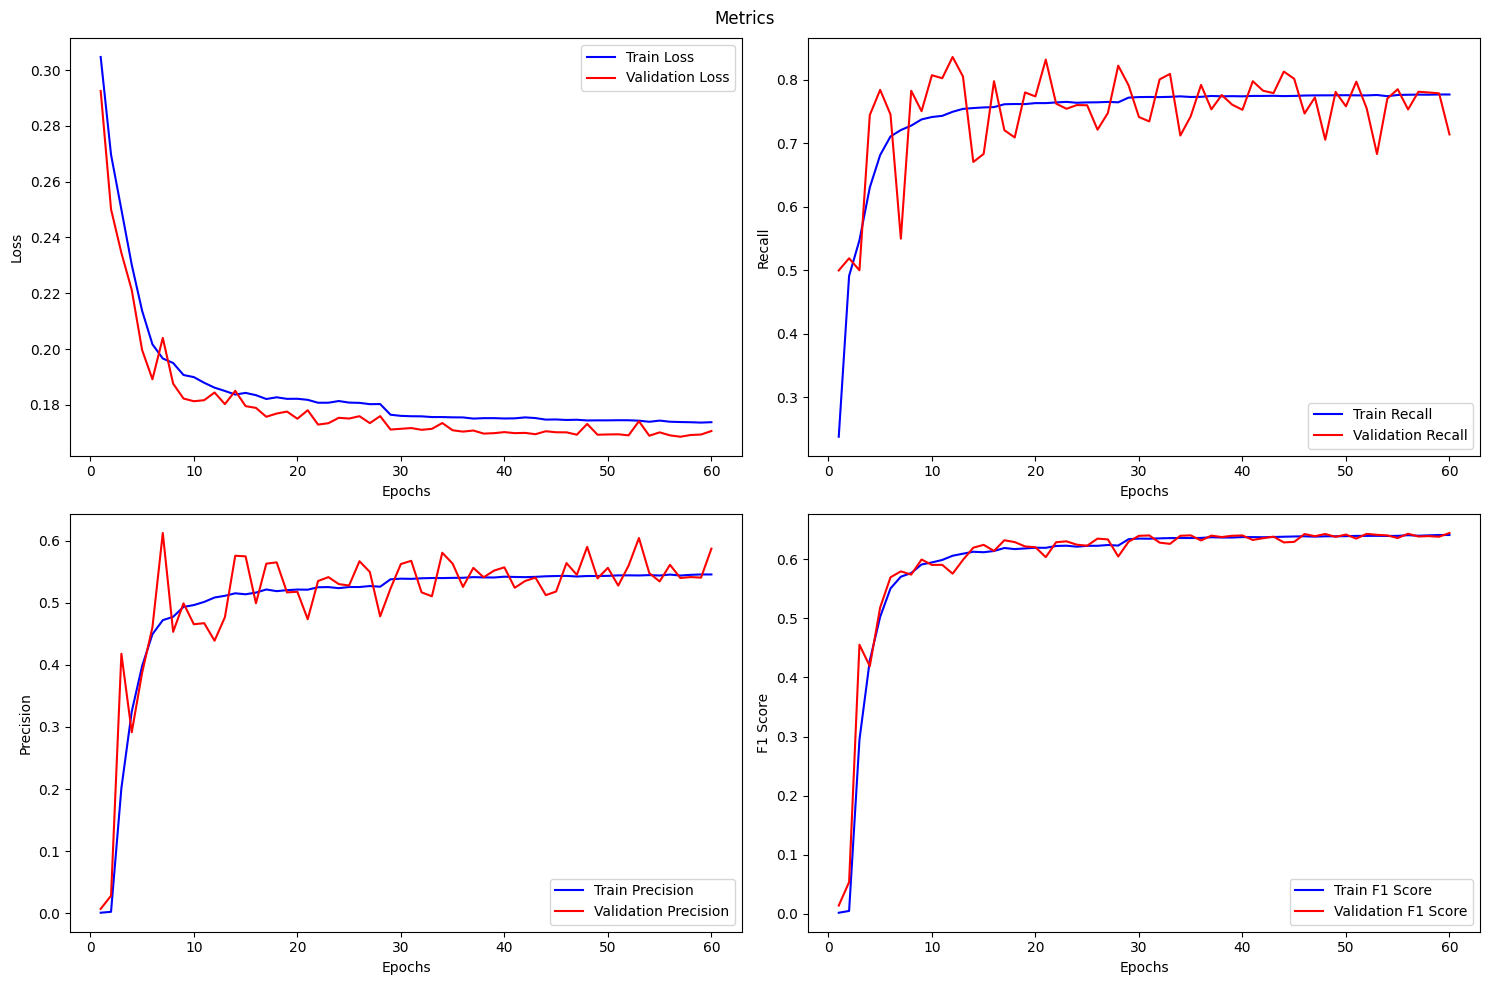

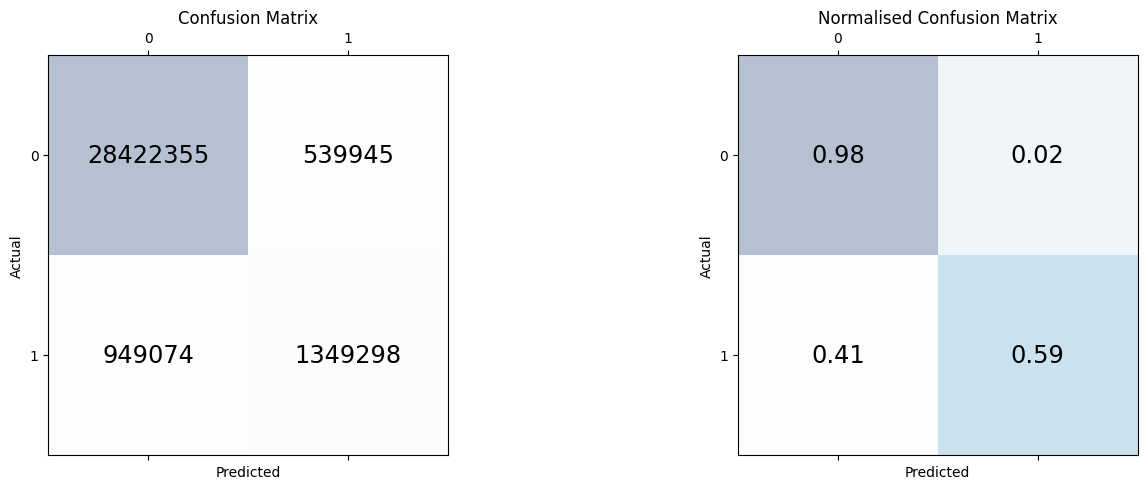

Best epoch: 57
Best validation loss: 0.1686
Best validation accuracy: 0.9551
Best validation precision: 0.5398
Best validation recall: 0.7813
Best validation f1 score: 0.6385
cuda
Epoch 1 train loss: 0.3573, validation loss: 0.3365, f1 score: 0.0141, accuracy: 0.9265, precision: 0.0071, recall: 0.5000
Epoch 6 train loss: 0.2767, validation loss: 0.2647, f1 score: 0.4163, accuracy: 0.9320, precision: 0.3296, recall: 0.5648
Epoch 11 train loss: 0.2349, validation loss: 0.2233, f1 score: 0.5686, accuracy: 0.9475, precision: 0.4702, recall: 0.7191
Epoch 16 train loss: 0.2194, validation loss: 0.2140, f1 score: 0.6004, accuracy: 0.9492, precision: 0.5187, recall: 0.7125
Epoch 21 train loss: 0.2140, validation loss: 0.2082, f1 score: 0.6217, accuracy: 0.9506, precision: 0.5526, recall: 0.7105
Epoch 26 train loss: 0.2135, validation loss: 0.2084, f1 score: 0.6191, accuracy: 0.9527, precision: 0.5224, recall: 0.7598
Epoch 31 train loss: 0.2107, validation loss: 0.2079, f1 score: 0.6229, accura

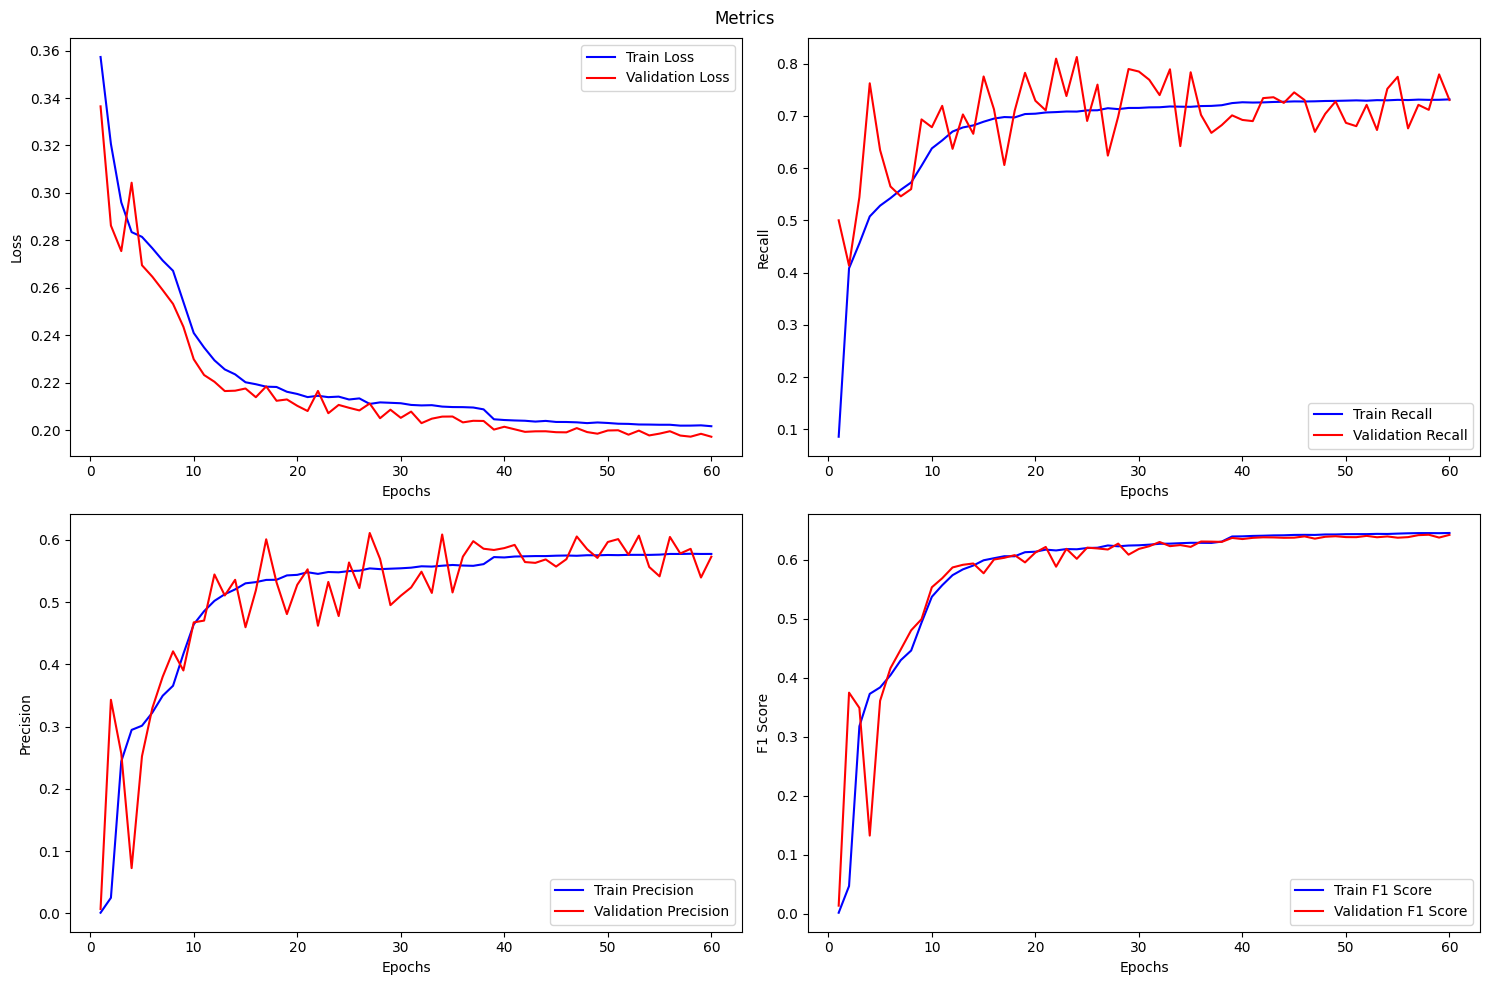

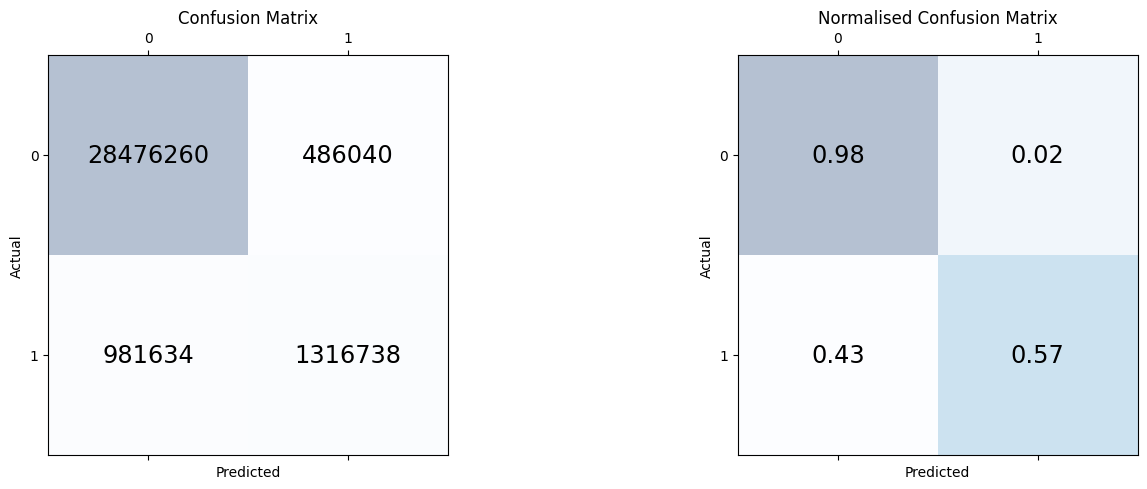

Best epoch: 60
Best validation loss: 0.1973
Best validation accuracy: 0.9531
Best validation precision: 0.5729
Best validation recall: 0.7304
Best validation f1 score: 0.6421
cuda
Epoch 1 train loss: 0.4221, validation loss: 0.3823, f1 score: 0.0229, accuracy: 0.9263, precision: 0.0118, recall: 0.4657
Epoch 6 train loss: 0.3064, validation loss: 0.2906, f1 score: 0.5257, accuracy: 0.9240, precision: 0.5727, recall: 0.4858
Epoch 11 train loss: 0.2678, validation loss: 0.2581, f1 score: 0.5964, accuracy: 0.9408, precision: 0.5945, recall: 0.5982
Epoch 16 train loss: 0.2604, validation loss: 0.2507, f1 score: 0.6041, accuracy: 0.9389, precision: 0.6341, recall: 0.5768
Epoch 21 train loss: 0.2579, validation loss: 0.2491, f1 score: 0.6230, accuracy: 0.9489, precision: 0.5737, recall: 0.6815
Epoch 26 train loss: 0.2558, validation loss: 0.2490, f1 score: 0.6263, accuracy: 0.9501, precision: 0.5685, recall: 0.6971
Epoch 31 train loss: 0.2549, validation loss: 0.2503, f1 score: 0.6265, accura

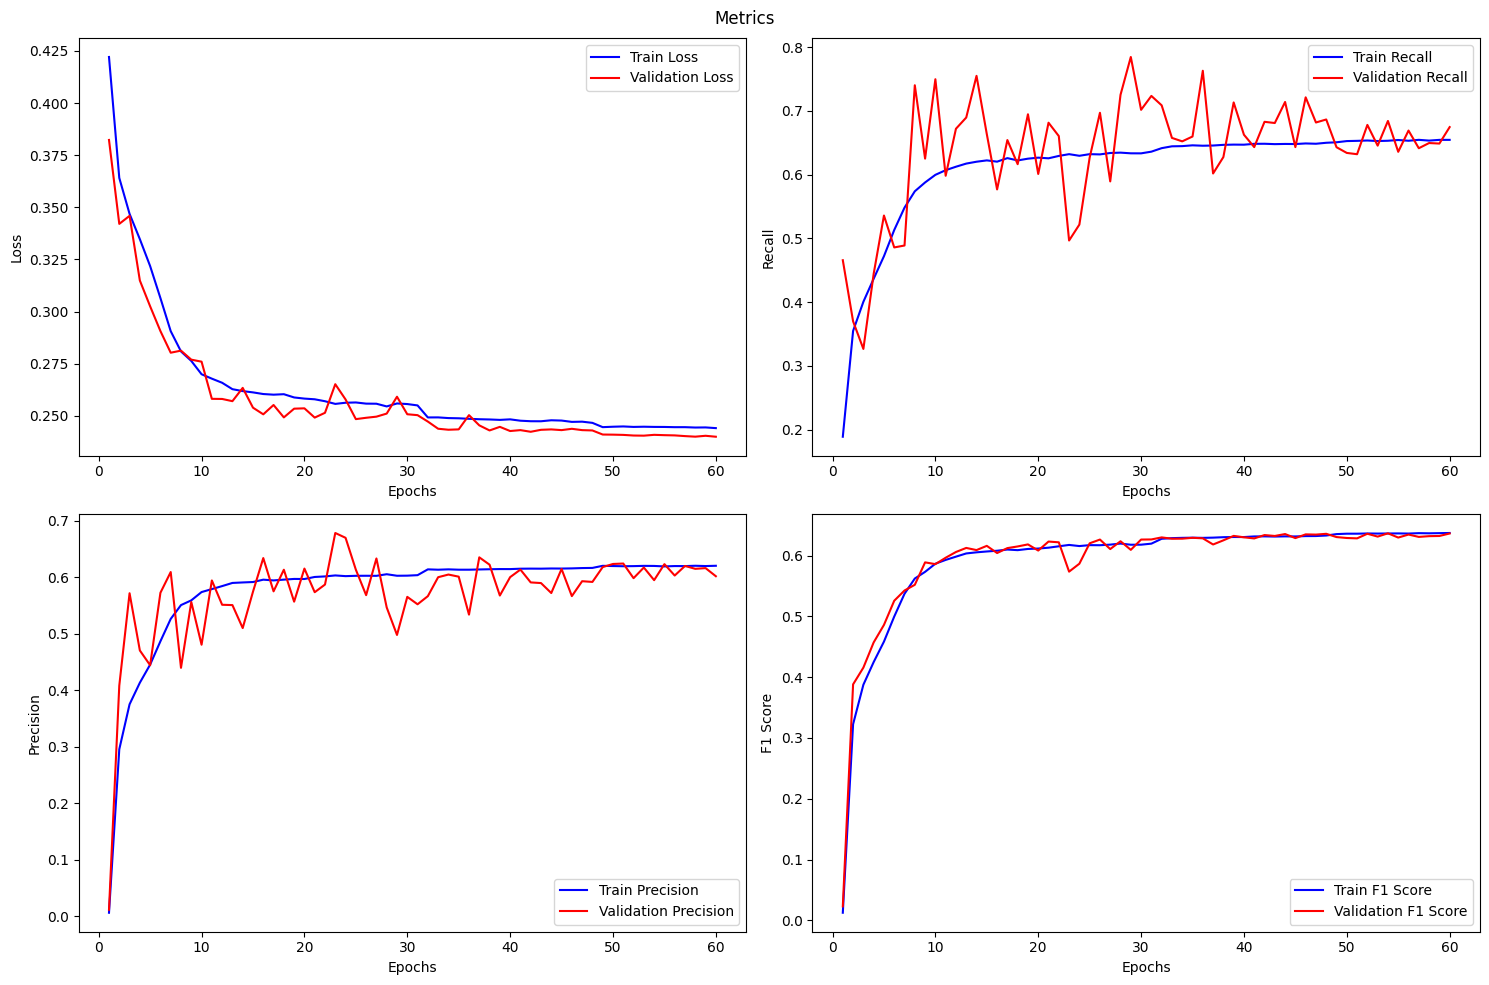

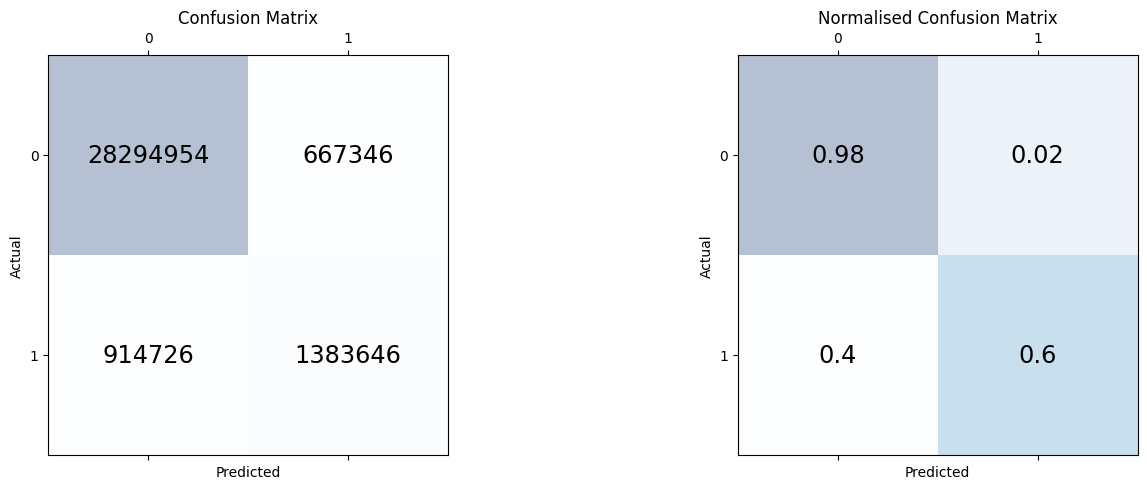

Best epoch: 60
Best validation loss: 0.2399
Best validation accuracy: 0.9494
Best validation precision: 0.6020
Best validation recall: 0.6746
Best validation f1 score: 0.6362


In [22]:
build_up_weight = [1.5, 2.0, 3.0]

for weight in build_up_weight:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    NUM_CHANNELS = 4
    NUM_CLASSES = 2

    num_epochs = 60
    lr = 0.003
    weight_decay = 1e-5
    batch_size = 16

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    model = SimpleCNN(NUM_CHANNELS, NUM_CLASSES)
    model.to(device)
    model = nn.DataParallel(model)
    weights = torch.tensor([1.0, weight]).to(device)  # Weight the loss function to account for class imbalance
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5)


    train_results = {
        "train_loss": [],
        "train_accuracy": [],
        "train_precision": [],
        "train_recall": [],
        "train_f1_score": []
    }

    val_results = {
        "val_loss": [],
        "val_accuracy": [],
        "val_precision": [],
        "val_recall": [],
        "val_f1_score": []
    }

    best_val_loss = np.inf
    best_model = None
    patience = 10
    best_epoch = 0


    # Train model
    for epoch in range(num_epochs):
        
        # train model
        running_loss, running_confusion_matrix = train_model(model, optimizer, criterion, train_dataloader, device, NUM_CLASSES, model_type='CNN')

        # Validate model
        running_val_loss, running_val_confusion_matrix = validate_model(model, criterion, val_dataloader, device, NUM_CLASSES, model_type='CNN')

        # Early stopping
        if running_val_loss < best_val_loss:
            best_val_loss = running_val_loss
            best_model = model.state_dict().copy()
            best_epoch = epoch
            patience = 10
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping")
                break

        # Calculate epoch metrics
        epoch_train_loss = running_loss / len(train_dataloader)
        epoch_train_accuracy = running_confusion_matrix.trace() / running_confusion_matrix.sum()
        epoch_recall = running_confusion_matrix[1, 1] / (running_confusion_matrix[1, 1] + running_confusion_matrix[0, 1] + 1e-5)
        epoch_precision = running_confusion_matrix[1, 1] / (running_confusion_matrix[1, 1] + running_confusion_matrix[1, 0] + 1e-5)
        epoch_f1_score = 2 * (epoch_precision * epoch_recall) / (epoch_precision + epoch_recall + 1e-5)

        epoch_val_loss = running_val_loss / len(val_dataloader)
        epoch_val_accuracy = running_val_confusion_matrix.trace() / running_val_confusion_matrix.sum()
        epoch_val_recall = running_val_confusion_matrix[1, 1] / (running_val_confusion_matrix[1, 1] + running_val_confusion_matrix[0, 1] + 1e-5)
        epoch_val_precision = running_val_confusion_matrix[1, 1] / (running_val_confusion_matrix[1, 1] + running_val_confusion_matrix[1, 0] + 1e-5)
        epoch_val_f1_score = 2 * (epoch_val_precision * epoch_val_recall) / (epoch_val_precision + epoch_val_recall + 1e-5)

        # Udpate results dictionary
        train_results["train_loss"].append(epoch_train_loss)
        train_results["train_accuracy"].append(epoch_train_accuracy)
        train_results["train_precision"].append(epoch_precision)
        train_results["train_recall"].append(epoch_recall)
        train_results["train_f1_score"].append(epoch_f1_score)

        val_results["val_loss"].append(epoch_val_loss)
        val_results["val_accuracy"].append(epoch_val_accuracy)
        val_results["val_precision"].append(epoch_val_precision)
        val_results["val_recall"].append(epoch_val_recall)
        val_results["val_f1_score"].append(epoch_val_f1_score)

        if (epoch) % 5 == 0:
            print(f"Epoch {epoch+1} train loss: {epoch_train_loss:.4f}, validation loss: {epoch_val_loss:.4f}, f1 score: {epoch_val_f1_score:.4f}, accuracy: {epoch_val_accuracy:.4f}, precision: {epoch_val_precision:.4f}, recall: {epoch_val_recall:.4f}")

        # Update learning rate
        scheduler.step(epoch_val_loss)

    # Save model
    saved_f1 = np.round(val_results["val_f1_score"][np.argmin(val_results["val_loss"])], 2)
    PATH = f"SimpleCNN_bestf1_{saved_f1}_bupweight_{weight}.pth"
    torch.save(best_model, PATH)

    print("------------------------------------")
    print("Results for build-up weight:", weight)
    print("------------------------------------")
    plot_metrics(train_results, val_results)
    plot_conf_matrix(running_val_confusion_matrix)
    print(f"Best epoch: {best_epoch+1}")
    print(f"Best validation loss: {val_results['val_loss'][best_epoch]:.4f}")
    print(f"Best validation accuracy: {val_results['val_accuracy'][best_epoch]:.4f}")
    print(f"Best validation precision: {val_results['val_precision'][best_epoch]:.4f}")
    print(f"Best validation recall: {val_results['val_recall'][best_epoch]:.4f}")
    print(f"Best validation f1 score: {val_results['val_f1_score'][best_epoch]:.4f}")

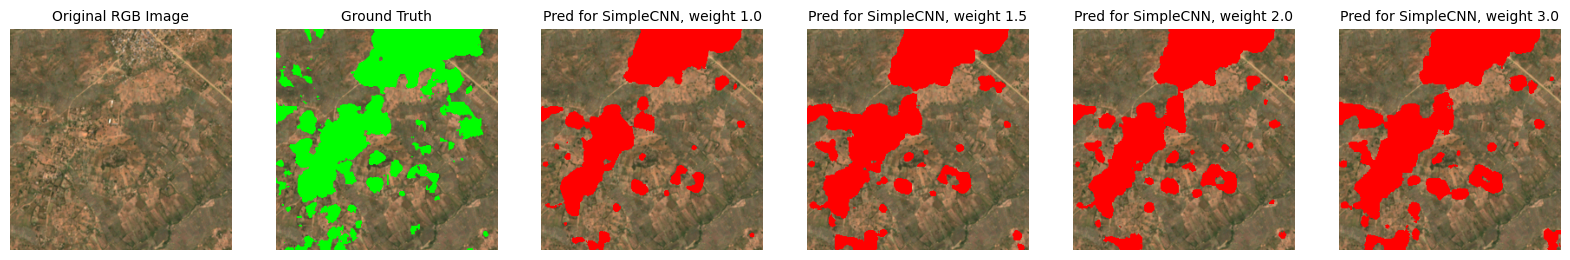

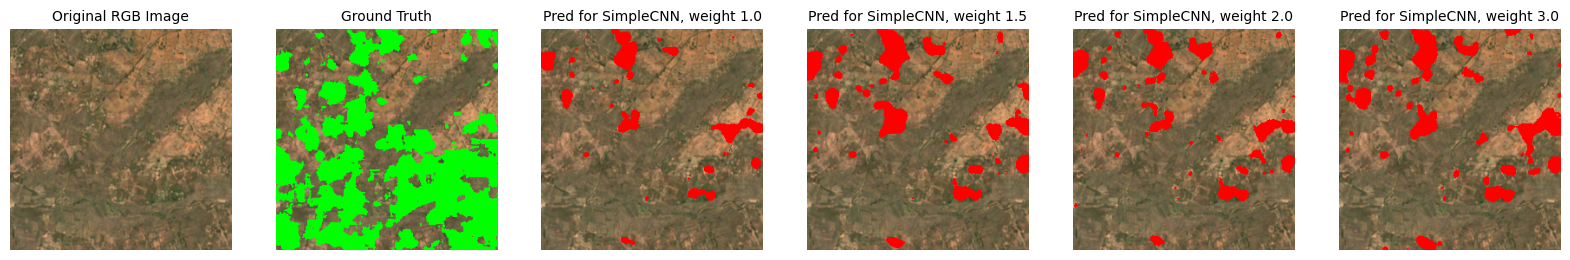

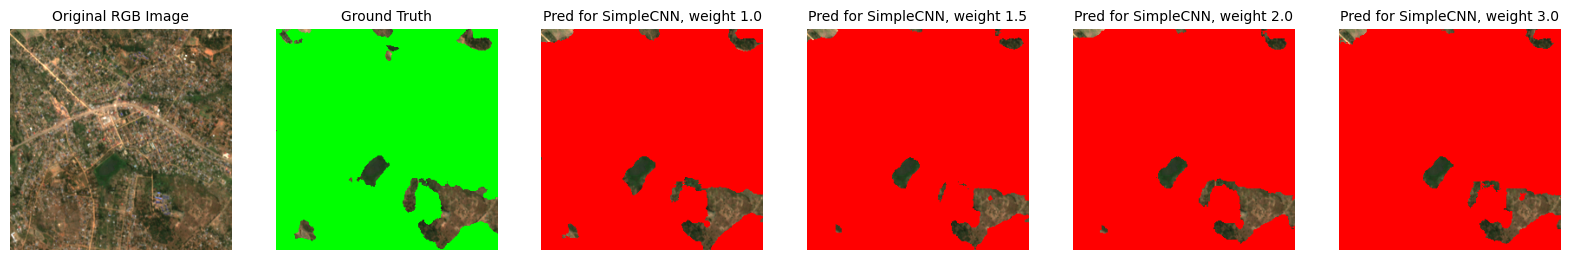

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CHANNELS = 4
NUM_CLASSES = 2
base_path = "saved_models"
model_names = ["SimpleCNN_bestf1_061.pth", "SimpleCNN_bestf1_0.64_bupweight_1.5.pth", 
         "SimpleCNN_bestf1_0.64_bupweight_2.0.pth", "SimpleCNN_bestf1_0.64_bupweight_3.0.pth"] 
PATHS = [base_path + "/" + name for name in model_names]

dataset_seperated = Smoothed_H5Dataset(h5_files, blt_files, patch_size=(256, 256), relevant_threshold=0.3, return_rgb_nir_separately=True)
dataset_for_prediction = Smoothed_H5Dataset(h5_files, blt_files, patch_size=(256, 256), relevant_threshold=0.3, return_rgb_nir_separately=False)

models = ["SimpleCNN, weight 1.0", "SimpleCNN, weight 1.5", "SimpleCNN, weight 2.0", "SimpleCNN, weight 3.0"]

for i in [1, 10, 170]:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()
    truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()

    path_predictions = []
    for PATH in PATHS:
        model = load_model(SimpleCNN, PATH, device, NUM_CHANNELS, NUM_CLASSES)
        pred = predict_on_patch(model, dataset_for_prediction, i, device)
        path_predictions.append(pred)
        # Plot prediction and ground truth overlayed on rgb image
    
    plot_with_overlays(rgb, truth, path_predictions, model_names=models)


In [50]:
dataset = Smoothed_H5Dataset(h5_files, blt_files, patch_size=(256, 256), relevant_threshold=0.0, return_rgb_nir_separately=False, augment=True, num_augment=1)
val_dataset_non_augment = Smoothed_H5Dataset(h5_files, blt_files, patch_size=(256, 256), relevant_threshold=0.0, return_rgb_nir_separately=False, augment=False)
# Split dataset into train and validation set (80/20)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset_augment = torch.utils.data.random_split(dataset, [train_size, val_size])

# Select index from val_dataset_augment to val_dataset
val_indices = val_dataset_augment.indices
val_dataset_non_augment = torch.utils.data.Subset(val_dataset, val_indices)

### 4.4 CNN architecture adjustments

In [ ]:
# Define model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CHANNELS = 4
NUM_CLASSES = 2

num_epochs = 50
lr = 0.004
weight_decay = 1e-5
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
model = AdvancedCNN(NUM_CHANNELS, NUM_CLASSES)
model.to(device)
model = nn.DataParallel(model)
weights = torch.tensor([1.0, 1.0]).to(device)  # Weight the loss function to account for class imbalance
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5)


train_results = {
    "train_loss": [],
    "train_accuracy": [],
    "train_precision": [],
    "train_recall": [],
    "train_f1_score": []
}

val_results = {
    "val_loss": [],
    "val_accuracy": [],
    "val_precision": [],
    "val_recall": [],
    "val_f1_score": []
}

best_val_loss = np.inf
best_model = None
patience = 10


# Train model
for epoch in range(num_epochs):
    
    # train model
    running_loss, running_confusion_matrix = train_model(model, optimizer, criterion, train_dataloader, device, NUM_CLASSES, model_type='CNN')

    # Validate model
    running_val_loss, running_val_confusion_matrix = validate_model(model, criterion, val_dataloader, device, NUM_CLASSES, model_type='CNN')

     # Early stopping
    if running_val_loss < best_val_loss:
        best_val_loss = running_val_loss
        best_model = model.state_dict().copy()
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

    # Calculate epoch metrics
    epoch_train_loss = running_loss / len(train_dataloader)
    epoch_train_accuracy = running_confusion_matrix.trace() / running_confusion_matrix.sum()
    epoch_recall = running_confusion_matrix[1, 1] / (running_confusion_matrix[1, 1] + running_confusion_matrix[0, 1] + 1e-5)
    epoch_precision = running_confusion_matrix[1, 1] / (running_confusion_matrix[1, 1] + running_confusion_matrix[1, 0] + 1e-5)
    epoch_f1_score = 2 * (epoch_precision * epoch_recall) / (epoch_precision + epoch_recall + 1e-5)

    epoch_val_loss = running_val_loss / len(val_dataloader)
    epoch_val_accuracy = running_val_confusion_matrix.trace() / running_val_confusion_matrix.sum()
    epoch_val_recall = running_val_confusion_matrix[1, 1] / (running_val_confusion_matrix[1, 1] + running_val_confusion_matrix[0, 1] + 1e-5)
    epoch_val_precision = running_val_confusion_matrix[1, 1] / (running_val_confusion_matrix[1, 1] + running_val_confusion_matrix[1, 0] + 1e-5)
    epoch_val_f1_score = 2 * (epoch_val_precision * epoch_val_recall) / (epoch_val_precision + epoch_val_recall + 1e-5)

    # Udpate results dictionary
    train_results["train_loss"].append(epoch_train_loss)
    train_results["train_accuracy"].append(epoch_train_accuracy)
    train_results["train_precision"].append(epoch_precision)
    train_results["train_recall"].append(epoch_recall)
    train_results["train_f1_score"].append(epoch_f1_score)

    val_results["val_loss"].append(epoch_val_loss)
    val_results["val_accuracy"].append(epoch_val_accuracy)
    val_results["val_precision"].append(epoch_val_precision)
    val_results["val_recall"].append(epoch_val_recall)
    val_results["val_f1_score"].append(epoch_val_f1_score)

    print(f"Epoch {epoch+1} train loss: {epoch_train_loss:.4f}, validation loss: {epoch_val_loss:.4f}, f1 score: {epoch_val_f1_score:.4f}, accuracy: {epoch_val_accuracy:.4f}, precision: {epoch_val_precision:.4f}, recall: {epoch_val_recall:.4f}")
    
    # Update learning rate
    scheduler.step(epoch_val_loss)

# Save model
saved_f1 = np.round(val_results["val_f1_score"][np.argmin(val_results["val_loss"])], 2)
PATH = f"ReducedCNN_bestf1_{saved_f1}.pth"
torch.save(best_model, PATH)

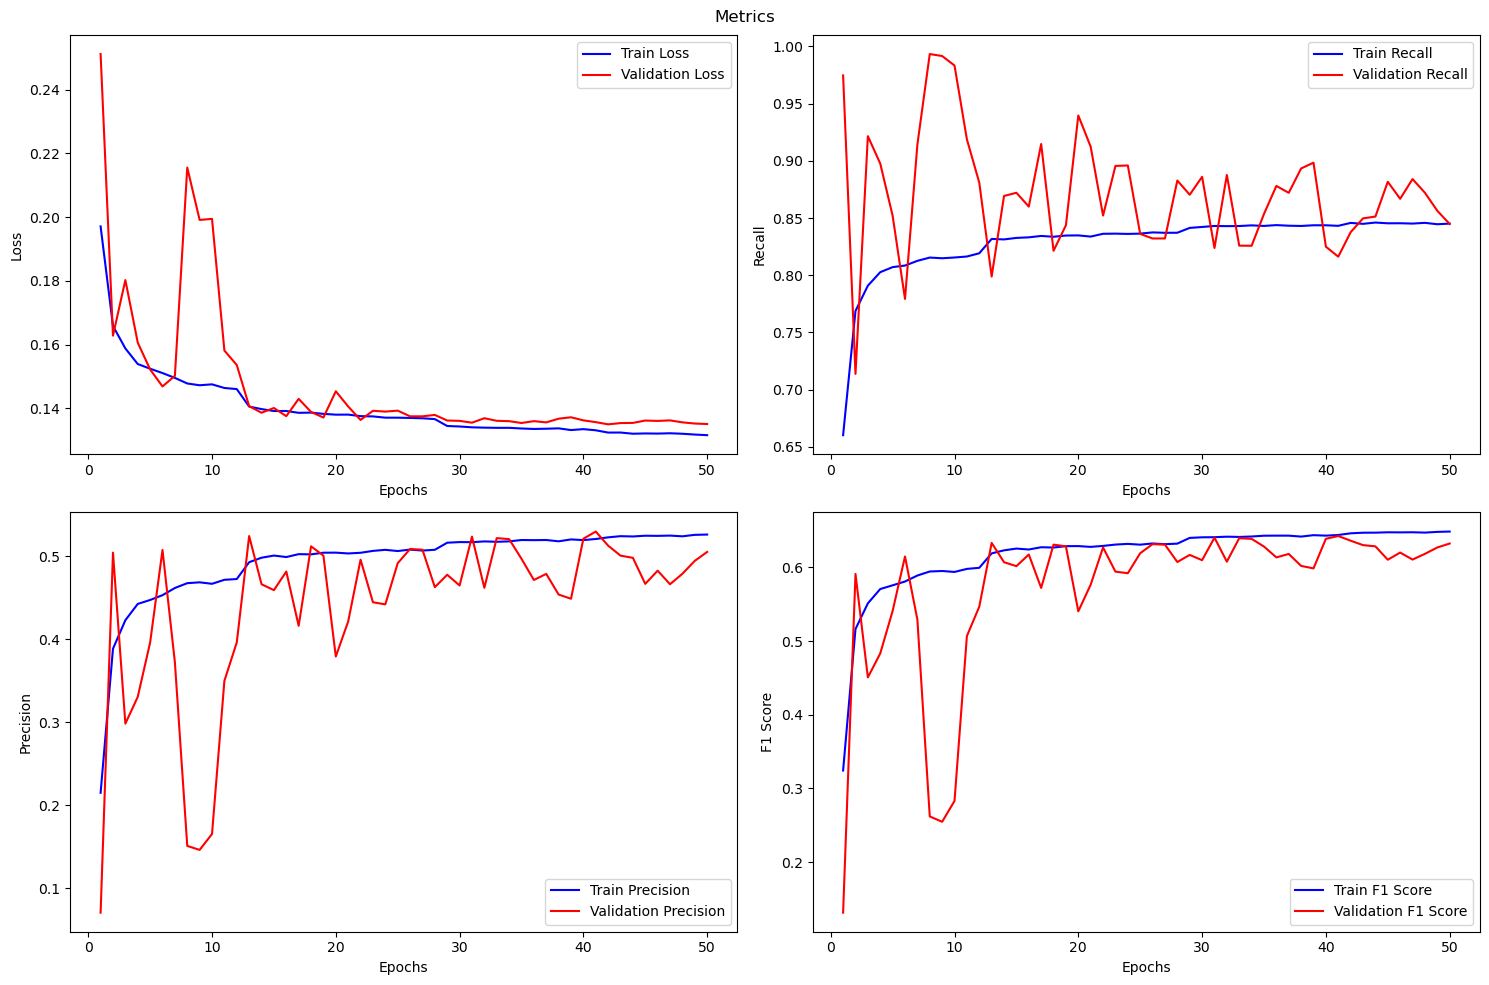

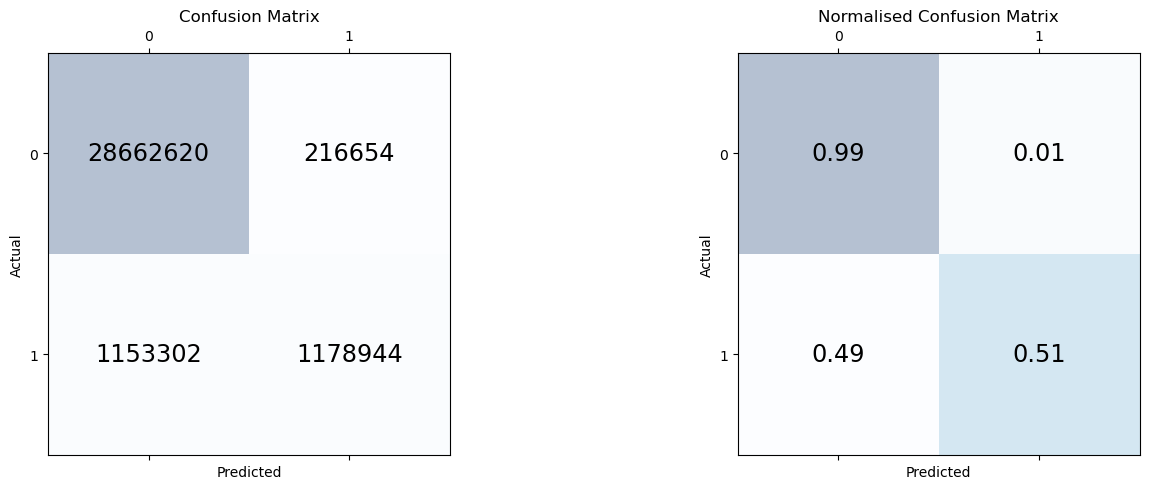

Best epoch: 42
Best validation loss: 0.1350
Best validation accuracy: 0.9562
Best validation precision: 0.5131
Best validation recall: 0.8376
Best validation f1 score: 0.6363


In [44]:
plot_metrics(train_results, val_results)
plot_conf_matrix(running_val_confusion_matrix)
best_epoch = np.argmin(val_results["val_loss"])
print(f"Best epoch: {best_epoch+1}")
print(f"Best validation loss: {val_results['val_loss'][best_epoch]:.4f}")
print(f"Best validation accuracy: {val_results['val_accuracy'][best_epoch]:.4f}")
print(f"Best validation precision: {val_results['val_precision'][best_epoch]:.4f}")
print(f"Best validation recall: {val_results['val_recall'][best_epoch]:.4f}")
print(f"Best validation f1 score: {val_results['val_f1_score'][best_epoch]:.4f}")

In [ ]:
# Define model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CHANNELS = 4
NUM_CLASSES = 2

num_epochs = 50
lr = 0.004
weight_decay = 1e-5
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
model = AdvancedCNN(NUM_CHANNELS, NUM_CLASSES)
model.to(device)
model = nn.DataParallel(model)
weights = torch.tensor([1.0, 1.5]).to(device)  # Weight the loss function to account for class imbalance
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5)


train_results = {
    "train_loss": [],
    "train_accuracy": [],
    "train_precision": [],
    "train_recall": [],
    "train_f1_score": []
}

val_results = {
    "val_loss": [],
    "val_accuracy": [],
    "val_precision": [],
    "val_recall": [],
    "val_f1_score": []
}

best_val_loss = np.inf
best_model = None
patience = 10


# Train model
for epoch in range(num_epochs):
    
    # train model
    running_loss, running_confusion_matrix = train_model(model, optimizer, criterion, train_dataloader, device, NUM_CLASSES, model_type='CNN')

    # Validate model
    running_val_loss, running_val_confusion_matrix = validate_model(model, criterion, val_dataloader, device, NUM_CLASSES, model_type='CNN')

     # Early stopping
    if running_val_loss < best_val_loss:
        best_val_loss = running_val_loss
        best_model = model.state_dict().copy()
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

    # Calculate epoch metrics
    epoch_train_loss = running_loss / len(train_dataloader)
    epoch_train_accuracy = running_confusion_matrix.trace() / running_confusion_matrix.sum()
    epoch_recall = running_confusion_matrix[1, 1] / (running_confusion_matrix[1, 1] + running_confusion_matrix[0, 1] + 1e-5)
    epoch_precision = running_confusion_matrix[1, 1] / (running_confusion_matrix[1, 1] + running_confusion_matrix[1, 0] + 1e-5)
    epoch_f1_score = 2 * (epoch_precision * epoch_recall) / (epoch_precision + epoch_recall + 1e-5)

    epoch_val_loss = running_val_loss / len(val_dataloader)
    epoch_val_accuracy = running_val_confusion_matrix.trace() / running_val_confusion_matrix.sum()
    epoch_val_recall = running_val_confusion_matrix[1, 1] / (running_val_confusion_matrix[1, 1] + running_val_confusion_matrix[0, 1] + 1e-5)
    epoch_val_precision = running_val_confusion_matrix[1, 1] / (running_val_confusion_matrix[1, 1] + running_val_confusion_matrix[1, 0] + 1e-5)
    epoch_val_f1_score = 2 * (epoch_val_precision * epoch_val_recall) / (epoch_val_precision + epoch_val_recall + 1e-5)

    # Udpate results dictionary
    train_results["train_loss"].append(epoch_train_loss)
    train_results["train_accuracy"].append(epoch_train_accuracy)
    train_results["train_precision"].append(epoch_precision)
    train_results["train_recall"].append(epoch_recall)
    train_results["train_f1_score"].append(epoch_f1_score)

    val_results["val_loss"].append(epoch_val_loss)
    val_results["val_accuracy"].append(epoch_val_accuracy)
    val_results["val_precision"].append(epoch_val_precision)
    val_results["val_recall"].append(epoch_val_recall)
    val_results["val_f1_score"].append(epoch_val_f1_score)

    print(f"Epoch {epoch+1} train loss: {epoch_train_loss:.4f}, validation loss: {epoch_val_loss:.4f}, f1 score: {epoch_val_f1_score:.4f}, accuracy: {epoch_val_accuracy:.4f}, precision: {epoch_val_precision:.4f}, recall: {epoch_val_recall:.4f}")
    
    # Update learning rate
    scheduler.step(epoch_val_loss)

# Save model
saved_f1 = np.round(val_results["val_f1_score"][np.argmin(val_results["val_loss"])], 2)
PATH = f"ReducedCNN_bestf1_{saved_f1}.pth"
torch.save(best_model, PATH)

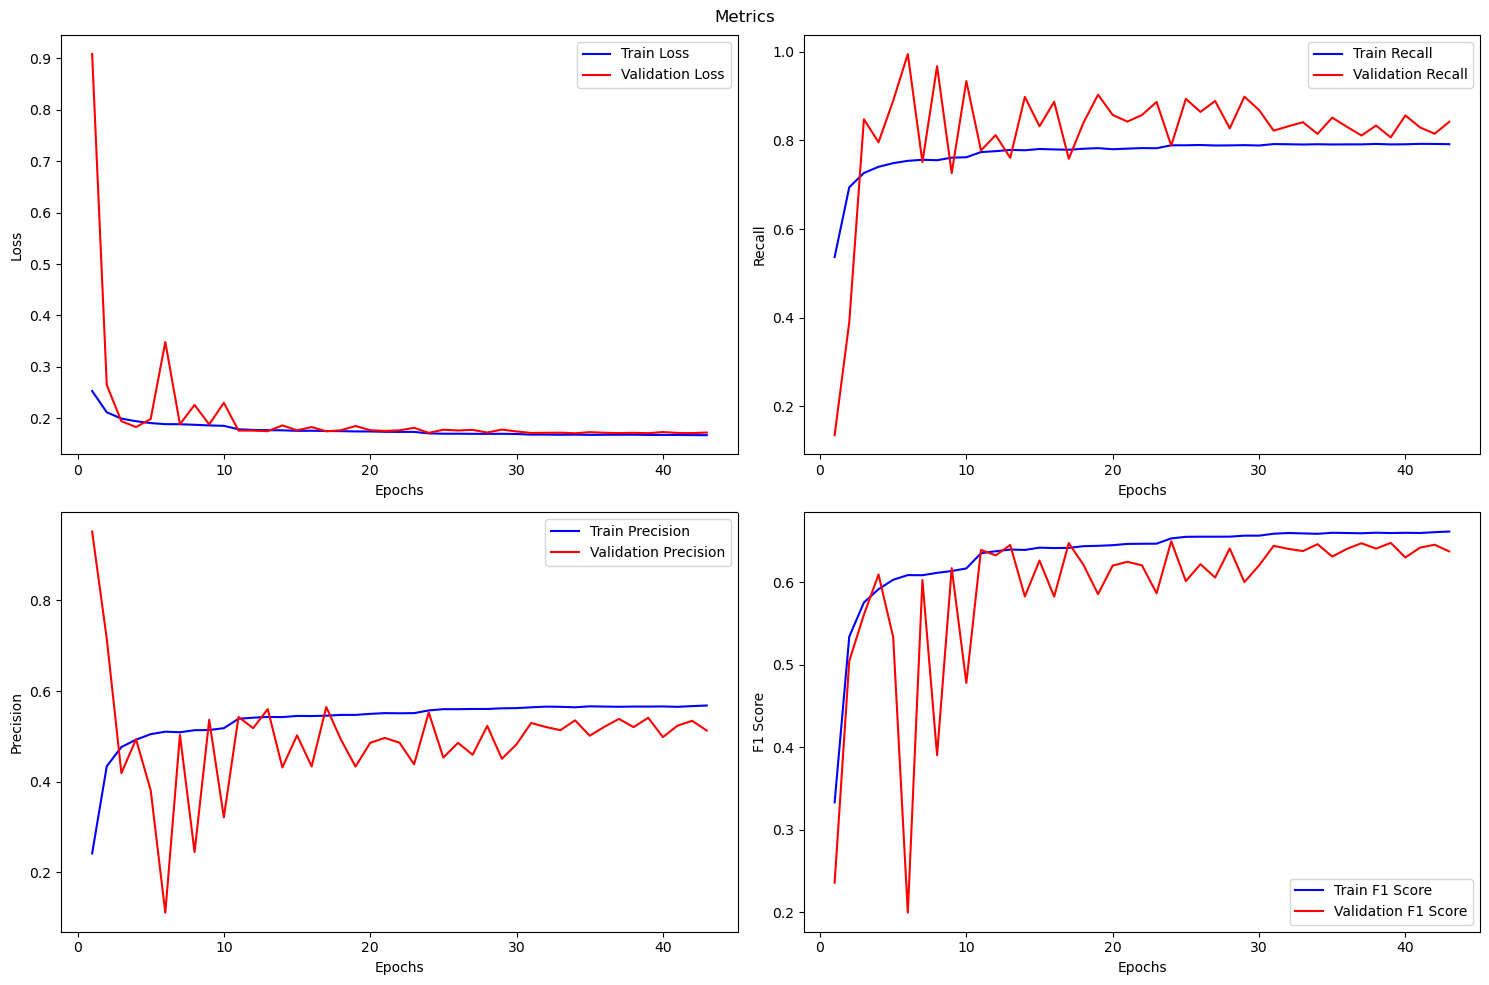

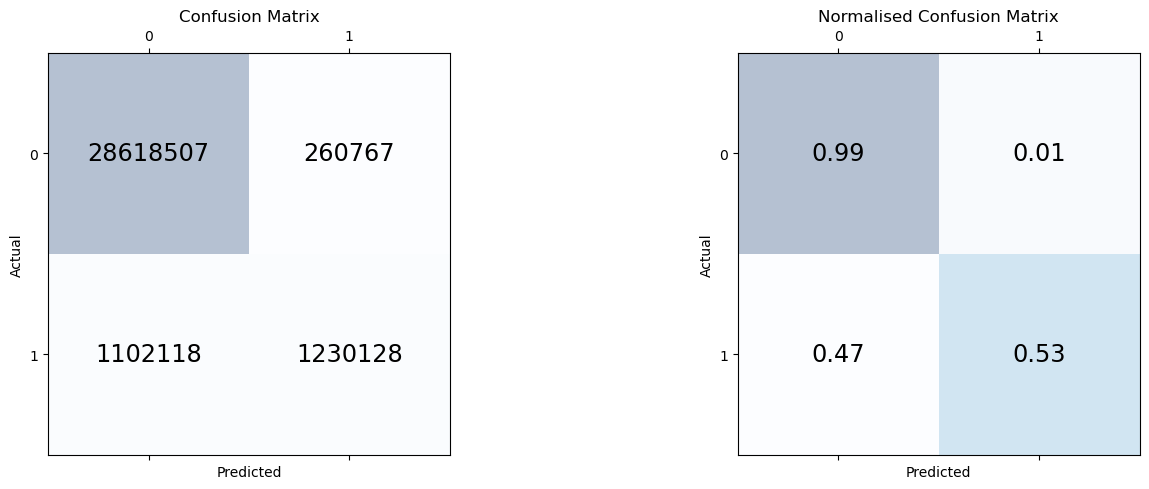

Best epoch: 34
Best validation loss: 0.1706
Best validation accuracy: 0.9562
Best validation precision: 0.5354
Best validation recall: 0.8149
Best validation f1 score: 0.6462


In [42]:
plot_metrics(train_results, val_results)
plot_conf_matrix(running_val_confusion_matrix)
best_epoch = np.argmin(val_results["val_loss"])
print(f"Best epoch: {best_epoch+1}")
print(f"Best validation loss: {val_results['val_loss'][best_epoch]:.4f}")
print(f"Best validation accuracy: {val_results['val_accuracy'][best_epoch]:.4f}")
print(f"Best validation precision: {val_results['val_precision'][best_epoch]:.4f}")
print(f"Best validation recall: {val_results['val_recall'][best_epoch]:.4f}")
print(f"Best validation f1 score: {val_results['val_f1_score'][best_epoch]:.4f}")


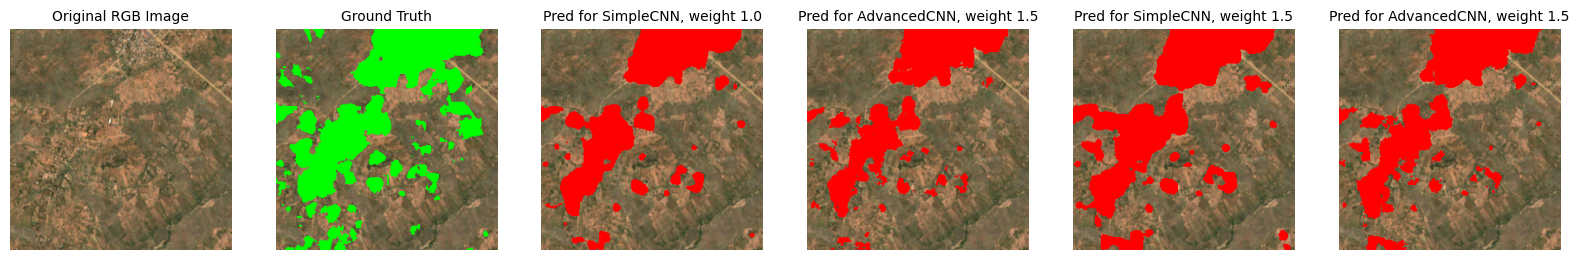

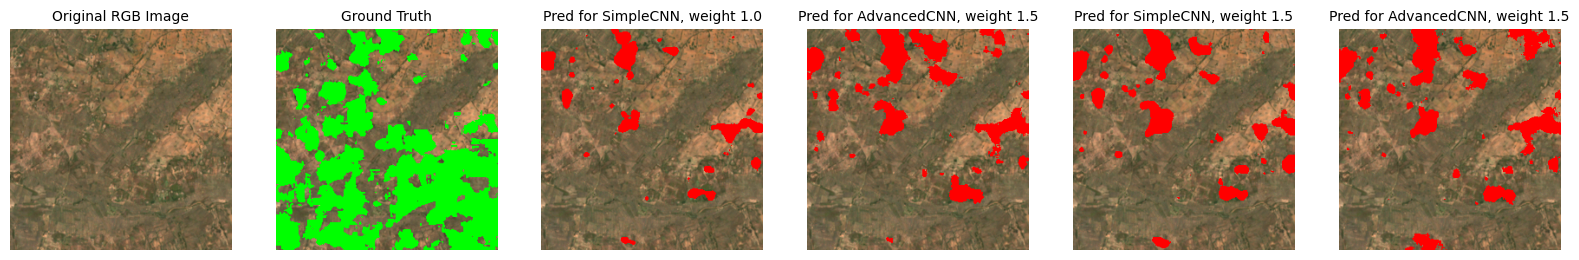

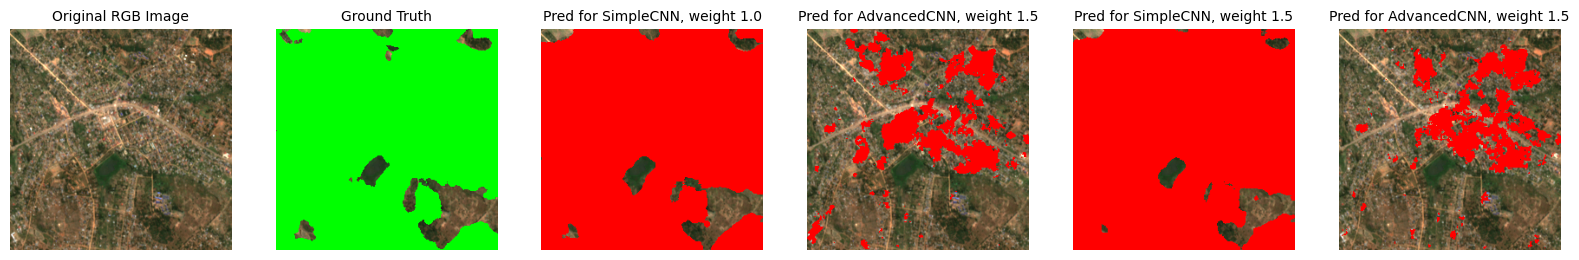

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CHANNELS = 4
NUM_CLASSES = 2
base_path = "saved_models"
model_names = ["SimpleCNN_bestf1_061.pth", "AdvancedCNN_bestf1_0.64.pth", "SimpleCNN_bestf1_0.64_bupweight_1.5.pth", "AdvancedCNN_bestf1_0.65_bupweight_1.5.pth"]
PATHS = [base_path + "/" + name for name in model_names]

dataset_seperated = Smoothed_H5Dataset(h5_files, blt_files, patch_size=(256, 256), relevant_threshold=0.3, return_rgb_nir_separately=True)
dataset_for_prediction = Smoothed_H5Dataset(h5_files, blt_files, patch_size=(256, 256), relevant_threshold=0.3, return_rgb_nir_separately=False)

model_names = ["SimpleCNN, weight 1.0", "AdvancedCNN, weight 1.5", "SimpleCNN, weight 1.5", "AdvancedCNN, weight 1.5"]
models = [SimpleCNN, AdvancedCNN, SimpleCNN, AdvancedCNN]

for i in [1, 10, 170]:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()
    truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()

    path_predictions = []
    for PATH, model in zip(PATHS, models):
        model = load_model(model, PATH, device, NUM_CHANNELS, NUM_CLASSES)
        pred = predict_on_patch(model, dataset_for_prediction, i, device)
        path_predictions.append(pred)
        # Plot prediction and ground truth overlayed on rgb image
    
    plot_with_overlays(rgb, truth, path_predictions, model_names=model_names)

### 4.5 Data Augmentation

In [16]:
base_path = "/home/pf/pfstud/mlarriere/not_aligned_data/"
h5_files = [f"{base_path}/tile_{i}_cloudfree.h5" for i in [0, 1, 3, 4]]
blt_files = [f"{base_path}/tile_{i}_BLT.h5" for i in [0, 1, 3, 4]]

dataset = Smoothed_H5Dataset(h5_files, blt_files, patch_size=(128, 128), relevant_threshold=0.0, return_rgb_nir_separately=False, augment=True, num_augment=3)
val_dataset_non_augment = Smoothed_H5Dataset(h5_files, blt_files, patch_size=(128, 128), relevant_threshold=0.0, return_rgb_nir_separately=False, augment=False, num_augment=3)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset_augment = torch.utils.data.random_split(dataset, [train_size, val_size])

# Select index from val_dataset_augment to val_dataset
val_indices = val_dataset_augment.indices
val_dataset_non_augment = torch.utils.data.Subset(val_dataset_non_augment, val_indices)

In [ ]:
# Define model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CHANNELS = 4
NUM_CLASSES = 2

num_epochs = 50
lr = 0.005
weight_decay = 1e-5
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset_non_augment, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
model = SimpleCNN(NUM_CHANNELS, NUM_CLASSES)
model.to(device)
model = nn.DataParallel(model)
weights = torch.tensor([1.0, 1.0]).to(device)  # Weight the loss function to account for class imbalance
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5)


train_results = {
    "train_loss": [],
    "train_accuracy": [],
    "train_precision": [],
    "train_recall": [],
    "train_f1_score": []
}

val_results = {
    "val_loss": [],
    "val_accuracy": [],
    "val_precision": [],
    "val_recall": [],
    "val_f1_score": []
}

best_val_loss = np.inf
best_model = None
patience = 10


# Train model
for epoch in range(num_epochs):
    
    # train model
    running_loss, running_confusion_matrix = train_model(model, optimizer, criterion, train_dataloader, device, NUM_CLASSES, model_type='CNN')

    # Validate model
    running_val_loss, running_val_confusion_matrix = validate_model(model, criterion, val_dataloader, device, NUM_CLASSES, model_type='CNN')

     # Early stopping
    if running_val_loss < best_val_loss:
        best_val_loss = running_val_loss
        best_model = model.state_dict().copy()
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

    # Calculate epoch metrics
    epoch_train_loss = running_loss / len(train_dataloader)
    epoch_train_accuracy = running_confusion_matrix.trace() / running_confusion_matrix.sum()
    epoch_recall = running_confusion_matrix[1, 1] / (running_confusion_matrix[1, 1] + running_confusion_matrix[0, 1] + 1e-5)
    epoch_precision = running_confusion_matrix[1, 1] / (running_confusion_matrix[1, 1] + running_confusion_matrix[1, 0] + 1e-5)
    epoch_f1_score = 2 * (epoch_precision * epoch_recall) / (epoch_precision + epoch_recall + 1e-5)

    epoch_val_loss = running_val_loss / len(val_dataloader)
    epoch_val_accuracy = running_val_confusion_matrix.trace() / running_val_confusion_matrix.sum()
    epoch_val_recall = running_val_confusion_matrix[1, 1] / (running_val_confusion_matrix[1, 1] + running_val_confusion_matrix[0, 1] + 1e-5)
    epoch_val_precision = running_val_confusion_matrix[1, 1] / (running_val_confusion_matrix[1, 1] + running_val_confusion_matrix[1, 0] + 1e-5)
    epoch_val_f1_score = 2 * (epoch_val_precision * epoch_val_recall) / (epoch_val_precision + epoch_val_recall + 1e-5)

    # Udpate results dictionary
    train_results["train_loss"].append(epoch_train_loss)
    train_results["train_accuracy"].append(epoch_train_accuracy)
    train_results["train_precision"].append(epoch_precision)
    train_results["train_recall"].append(epoch_recall)
    train_results["train_f1_score"].append(epoch_f1_score)

    val_results["val_loss"].append(epoch_val_loss)
    val_results["val_accuracy"].append(epoch_val_accuracy)
    val_results["val_precision"].append(epoch_val_precision)
    val_results["val_recall"].append(epoch_val_recall)
    val_results["val_f1_score"].append(epoch_val_f1_score)

    print(f"Epoch {epoch+1} train loss: {epoch_train_loss:.4f}, validation loss: {epoch_val_loss:.4f}, f1 score: {epoch_val_f1_score:.4f}, accuracy: {epoch_val_accuracy:.4f}, precision: {epoch_val_precision:.4f}, recall: {epoch_val_recall:.4f}")
    
    # Update learning rate
    scheduler.step(epoch_val_loss)

# Save model
saved_f1 = np.round(val_results["val_f1_score"][np.argmin(val_results["val_loss"])], 2)
PATH = f"Augmented_SimpleCNN_bestf1_{saved_f1}.pth"
torch.save(best_model, PATH)

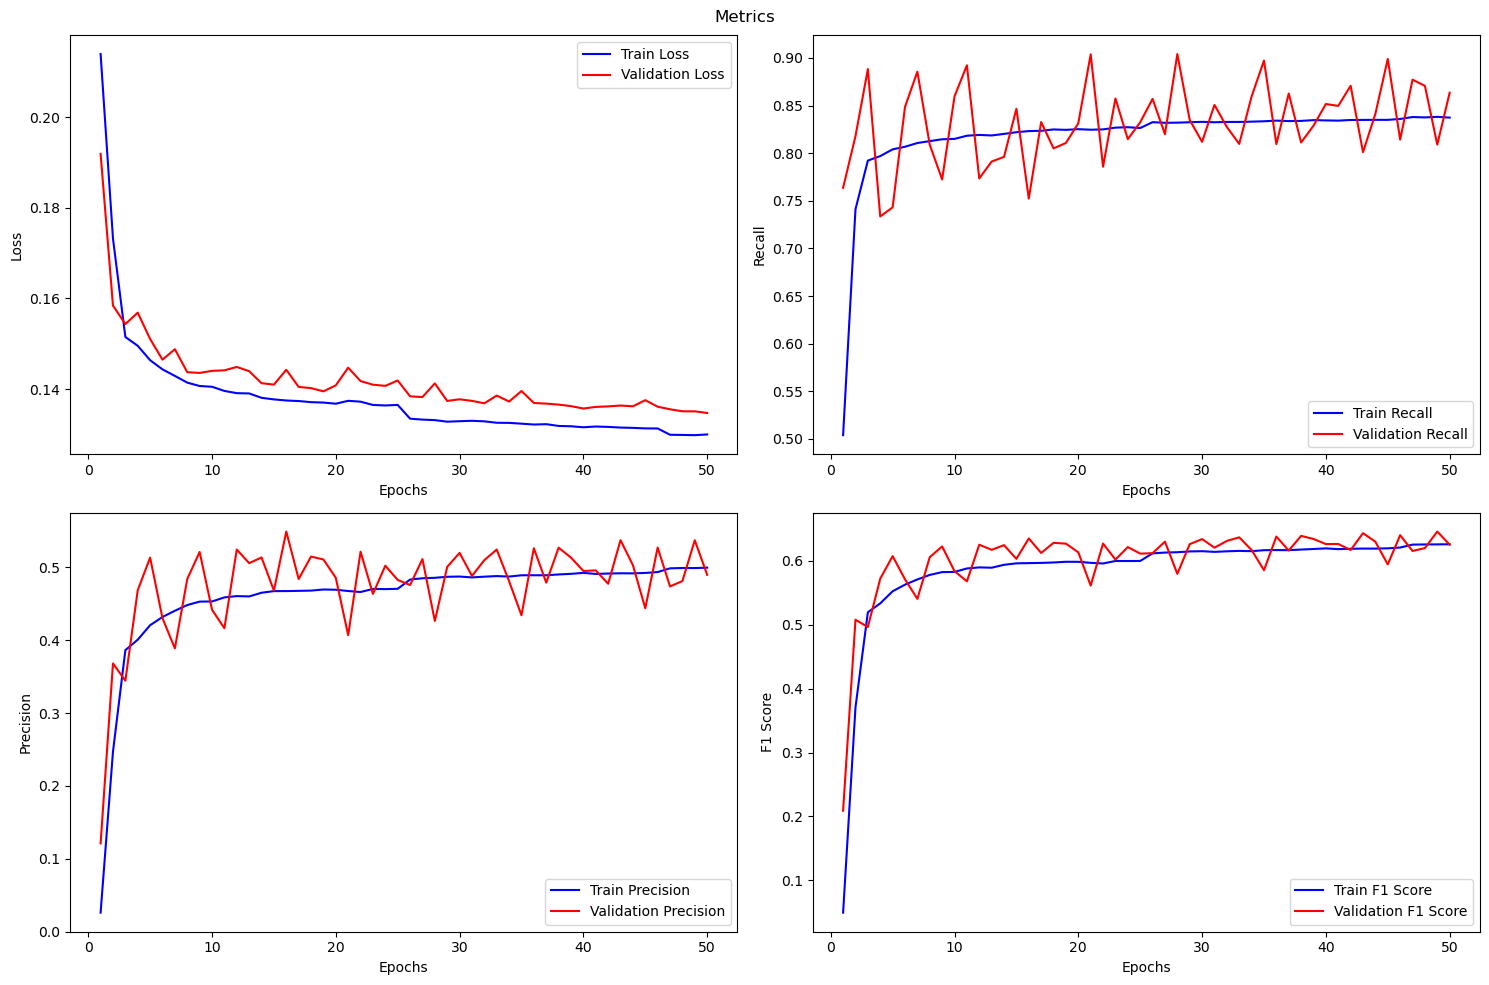

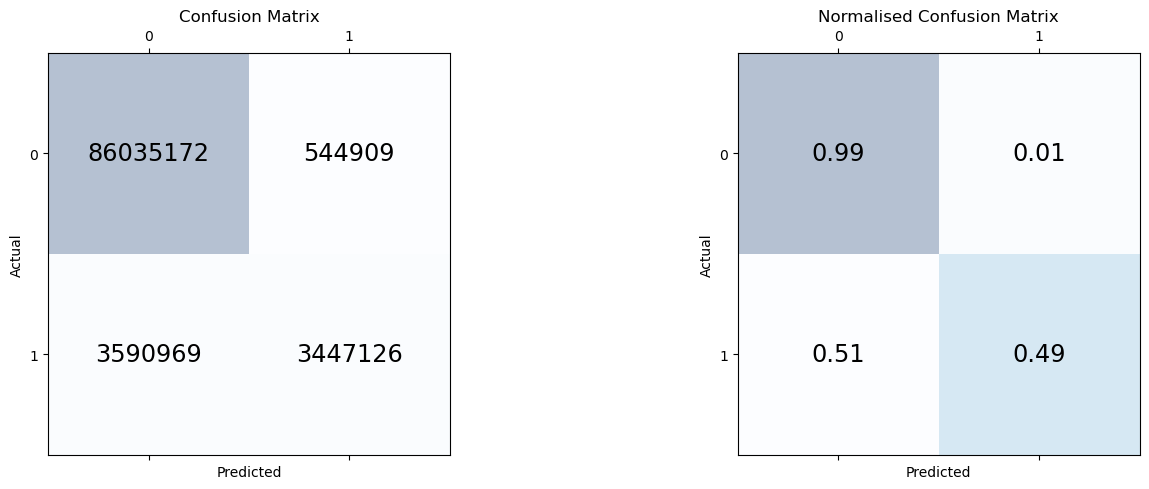

Best epoch: 50
Best validation loss: 0.1347
Best validation accuracy: 0.9558
Best validation precision: 0.4898
Best validation recall: 0.8635
Best validation f1 score: 0.6250


In [44]:
plot_metrics(train_results, val_results)
plot_conf_matrix(running_val_confusion_matrix)

# Print best model metrics
best_epoch = np.argmin(val_results["val_loss"])
print(f"Best epoch: {best_epoch+1}")
print(f"Best validation loss: {val_results['val_loss'][best_epoch]:.4f}")
print(f"Best validation accuracy: {val_results['val_accuracy'][best_epoch]:.4f}")
print(f"Best validation precision: {val_results['val_precision'][best_epoch]:.4f}")
print(f"Best validation recall: {val_results['val_recall'][best_epoch]:.4f}")
print(f"Best validation f1 score: {val_results['val_f1_score'][best_epoch]:.4f}")

In [ ]:
# Define model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CHANNELS = 4
NUM_CLASSES = 2

num_epochs = 50
lr = 0.005
weight_decay = 1e-5
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset_non_augment, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
model = SimpleCNN(NUM_CHANNELS, NUM_CLASSES)
model.to(device)
model = nn.DataParallel(model)
weights = torch.tensor([1.0, 1.5]).to(device)  # Weight the loss function to account for class imbalance
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5)


train_results = {
    "train_loss": [],
    "train_accuracy": [],
    "train_precision": [],
    "train_recall": [],
    "train_f1_score": []
}

val_results = {
    "val_loss": [],
    "val_accuracy": [],
    "val_precision": [],
    "val_recall": [],
    "val_f1_score": []
}

best_val_loss = np.inf
best_model = None
patience = 10


# Train model
for epoch in range(num_epochs):
    
    # train model
    running_loss, running_confusion_matrix = train_model(model, optimizer, criterion, train_dataloader, device, NUM_CLASSES, model_type='CNN')

    # Validate model
    running_val_loss, running_val_confusion_matrix = validate_model(model, criterion, val_dataloader, device, NUM_CLASSES, model_type='CNN')

     # Early stopping
    if running_val_loss < best_val_loss:
        best_val_loss = running_val_loss
        best_model = model.state_dict().copy()
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

    # Calculate epoch metrics
    epoch_train_loss = running_loss / len(train_dataloader)
    epoch_train_accuracy = running_confusion_matrix.trace() / running_confusion_matrix.sum()
    epoch_recall = running_confusion_matrix[1, 1] / (running_confusion_matrix[1, 1] + running_confusion_matrix[0, 1] + 1e-5)
    epoch_precision = running_confusion_matrix[1, 1] / (running_confusion_matrix[1, 1] + running_confusion_matrix[1, 0] + 1e-5)
    epoch_f1_score = 2 * (epoch_precision * epoch_recall) / (epoch_precision + epoch_recall + 1e-5)

    epoch_val_loss = running_val_loss / len(val_dataloader)
    epoch_val_accuracy = running_val_confusion_matrix.trace() / running_val_confusion_matrix.sum()
    epoch_val_recall = running_val_confusion_matrix[1, 1] / (running_val_confusion_matrix[1, 1] + running_val_confusion_matrix[0, 1] + 1e-5)
    epoch_val_precision = running_val_confusion_matrix[1, 1] / (running_val_confusion_matrix[1, 1] + running_val_confusion_matrix[1, 0] + 1e-5)
    epoch_val_f1_score = 2 * (epoch_val_precision * epoch_val_recall) / (epoch_val_precision + epoch_val_recall + 1e-5)

    # Udpate results dictionary
    train_results["train_loss"].append(epoch_train_loss)
    train_results["train_accuracy"].append(epoch_train_accuracy)
    train_results["train_precision"].append(epoch_precision)
    train_results["train_recall"].append(epoch_recall)
    train_results["train_f1_score"].append(epoch_f1_score)

    val_results["val_loss"].append(epoch_val_loss)
    val_results["val_accuracy"].append(epoch_val_accuracy)
    val_results["val_precision"].append(epoch_val_precision)
    val_results["val_recall"].append(epoch_val_recall)
    val_results["val_f1_score"].append(epoch_val_f1_score)

    print(f"Epoch {epoch+1} train loss: {epoch_train_loss:.4f}, validation loss: {epoch_val_loss:.4f}, f1 score: {epoch_val_f1_score:.4f}, accuracy: {epoch_val_accuracy:.4f}, precision: {epoch_val_precision:.4f}, recall: {epoch_val_recall:.4f}")
    
    # Update learning rate
    scheduler.step(epoch_val_loss)

# Save model
saved_f1 = np.round(val_results["val_f1_score"][np.argmin(val_results["val_loss"])], 2)
PATH = f"Augmented_SimpleCNN_bestf1_{saved_f1}.pth"
torch.save(best_model, PATH)

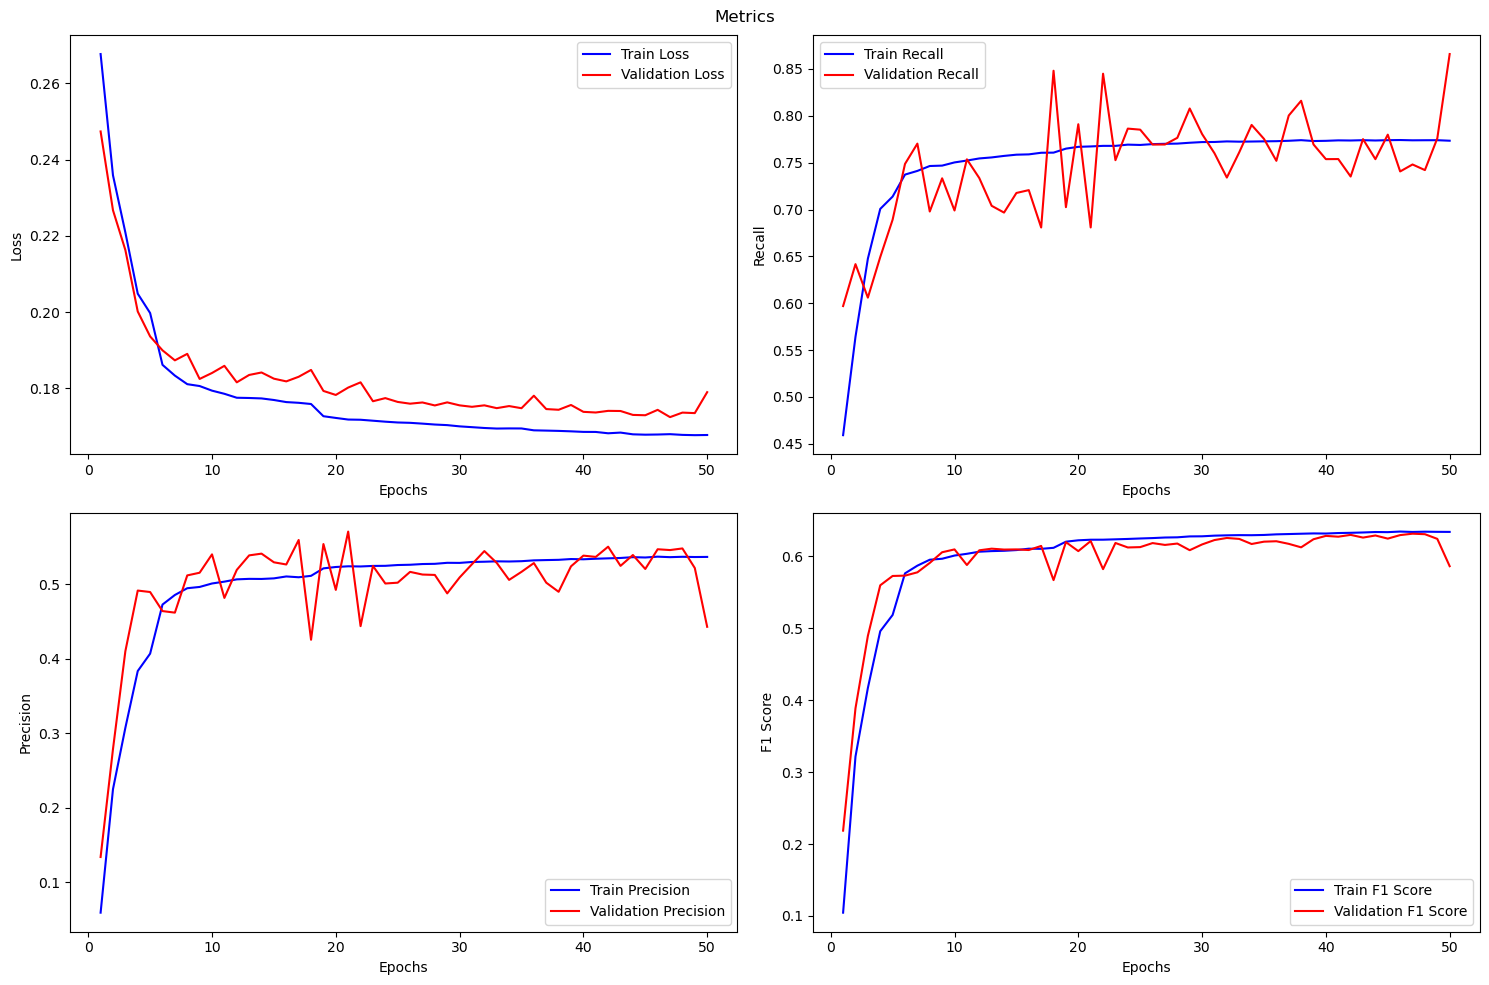

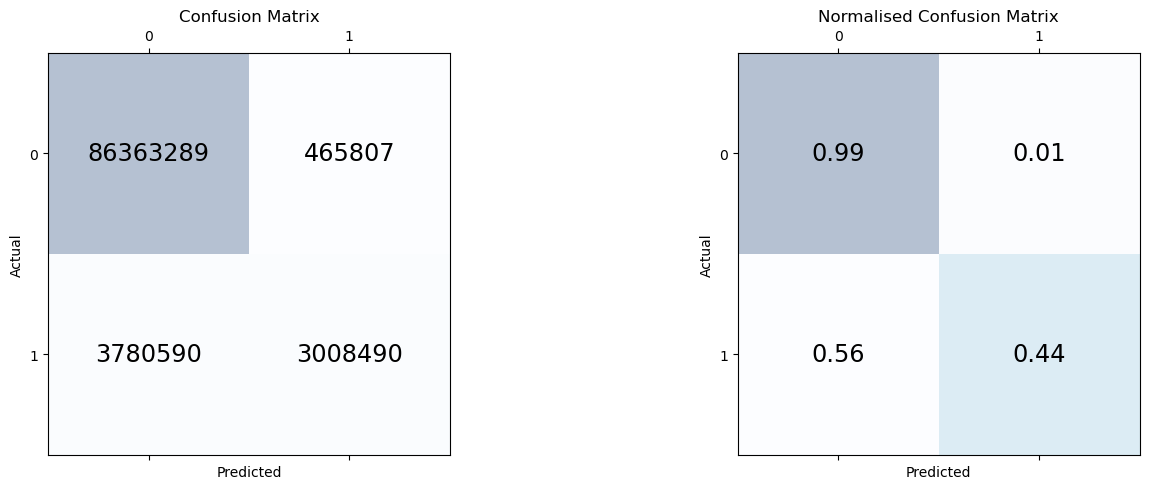

Best epoch: 47
Best validation loss: 0.1725
Best validation accuracy: 0.9538
Best validation precision: 0.5462
Best validation recall: 0.7481
Best validation f1 score: 0.6314


In [40]:
plot_metrics(train_results, val_results)
plot_conf_matrix(running_val_confusion_matrix)

# Print best model metrics
best_epoch = np.argmin(val_results["val_loss"])
print(f"Best epoch: {best_epoch+1}")
print(f"Best validation loss: {val_results['val_loss'][best_epoch]:.4f}")
print(f"Best validation accuracy: {val_results['val_accuracy'][best_epoch]:.4f}")
print(f"Best validation precision: {val_results['val_precision'][best_epoch]:.4f}")
print(f"Best validation recall: {val_results['val_recall'][best_epoch]:.4f}")
print(f"Best validation f1 score: {val_results['val_f1_score'][best_epoch]:.4f}")

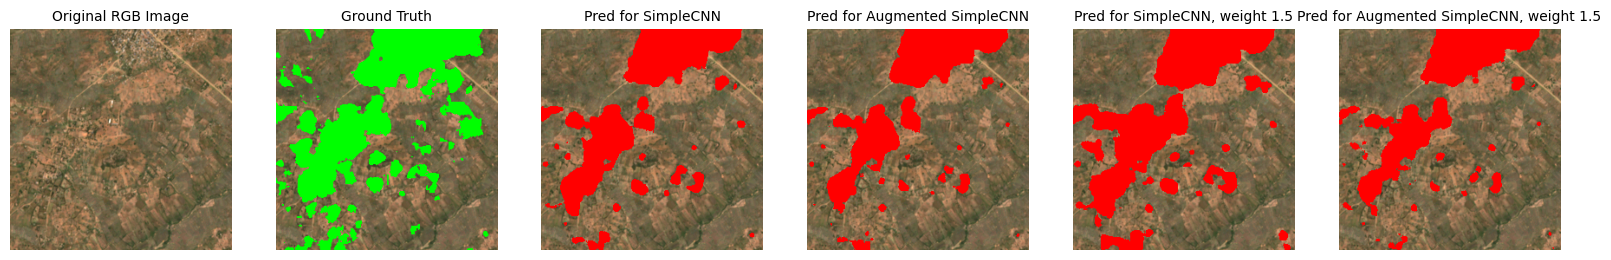

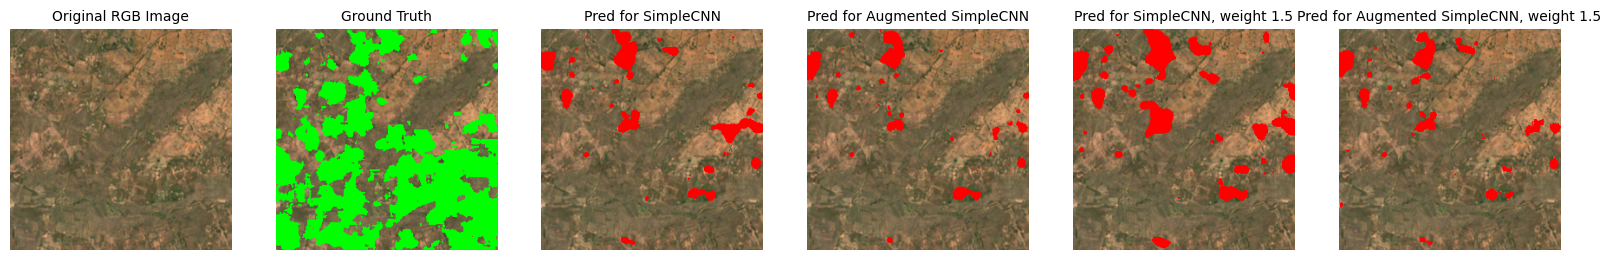

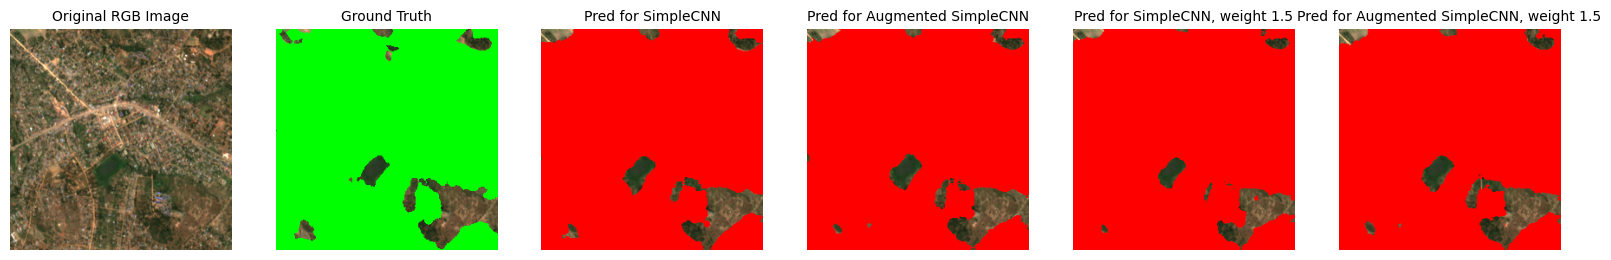

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CHANNELS = 4
NUM_CLASSES = 2
base_path = "saved_models"
model_names = ["SimpleCNN_bestf1_061.pth", "Augmented_SimpleCNN_bestf1_0.63.pth", "SimpleCNN_bestf1_0.64_bupweight_1.5.pth", "Augmented_SimpleCNN_bestf1_0.63_bupweight_1.5.pth"]
PATHS = [base_path + "/" + name for name in model_names]

dataset_seperated = Smoothed_H5Dataset(h5_files, blt_files, patch_size=(256, 256), relevant_threshold=0.3, return_rgb_nir_separately=True)
dataset_for_prediction = Smoothed_H5Dataset(h5_files, blt_files, patch_size=(256, 256), relevant_threshold=0.3, return_rgb_nir_separately=False)

models = ["SimpleCNN", "Augmented SimpleCNN", "SimpleCNN, weight 1.5", "Augmented SimpleCNN, weight 1.5"]

for i in [1, 10, 170]:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()
    truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()

    path_predictions = []
    for PATH in PATHS:
        model = load_model(SimpleCNN, PATH, device, NUM_CHANNELS, NUM_CLASSES)
        pred = predict_on_patch(model, dataset_for_prediction, i, device)
        path_predictions.append(pred)
        # Plot prediction and ground truth overlayed on rgb image
    
    plot_with_overlays(rgb, truth, path_predictions, model_names=models)

## 5. Testing

In [4]:
h5_testing_file = "/home/pf/pfstud/mlarriere/not_aligned_data/DAR_cloudfree.h5"
blt_testing_file = "/home/pf/pfstud/mlarriere/not_aligned_data/DAR_BLT.h5"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#----CustomDataset----
dataset = Custom_Testing_Dataset(h5_testing_file, blt_testing_file)

#----DataLoader----
batch_size = 64
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

num_batches = len(test_loader) #number of batches
total_objects = len(test_loader.dataset)#number of objects
print("Number of batches:", num_batches)
print("Total number of objects:", total_objects)

#----MODEL----
NUM_CHANNELS = 4
NUM_CLASSES = 2

#----LOAD MODEL----
PATH = "saved_models/Augmented_SimpleCNN_bestf1_0.63_bupweight_1.5.pth"
model = load_model(SimpleCNN, PATH, device, NUM_CHANNELS, NUM_CLASSES)

Number of batches: 90
Total number of objects: 5700


### 5.1 Plotting confusion matrix and single patches

Accuracy: 0.9268331552740783, f1 score: 0.7896, recall :0.7952838299194128, precision:0.7840139094894096


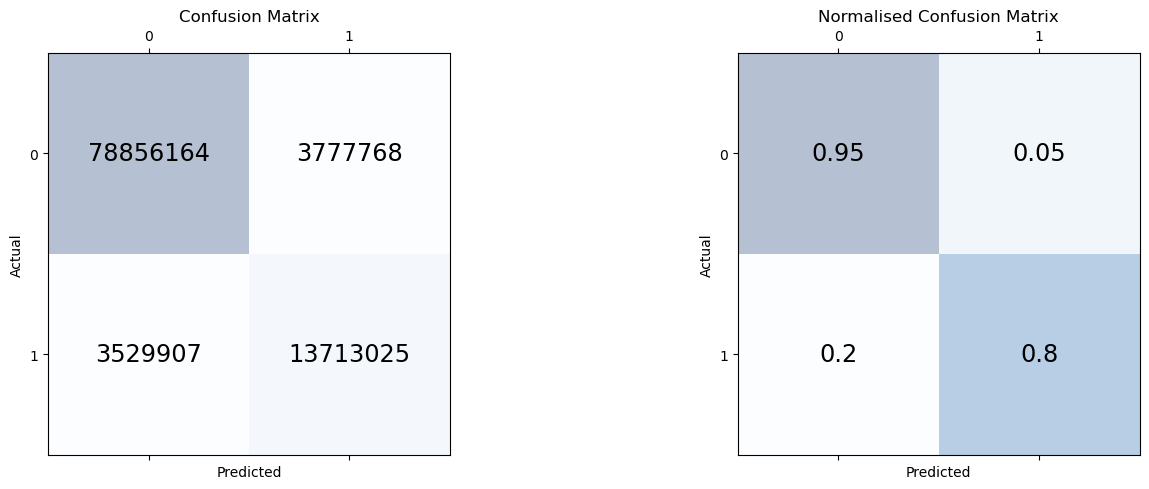

In [5]:
# Train model
running_confusion_matrix, predicted = testing_model(model, test_loader, device, NUM_CLASSES,  model_type = 'CNN')

# Calculate metrics
test_accuracy = running_confusion_matrix.trace() / running_confusion_matrix.sum()
test_recall = running_confusion_matrix[1, 1] / (running_confusion_matrix[1, 0] + running_confusion_matrix[1, 1])
test_precision = running_confusion_matrix[1, 1] / (running_confusion_matrix[0, 1] + running_confusion_matrix[1, 1])
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-5) #1e-5 to handle division by 0

print(f"Accuracy: {test_accuracy}, f1 score: {test_f1_score:.4f}, recall :{test_recall}, precision:{test_precision}")
plot_conf_matrix(running_confusion_matrix)

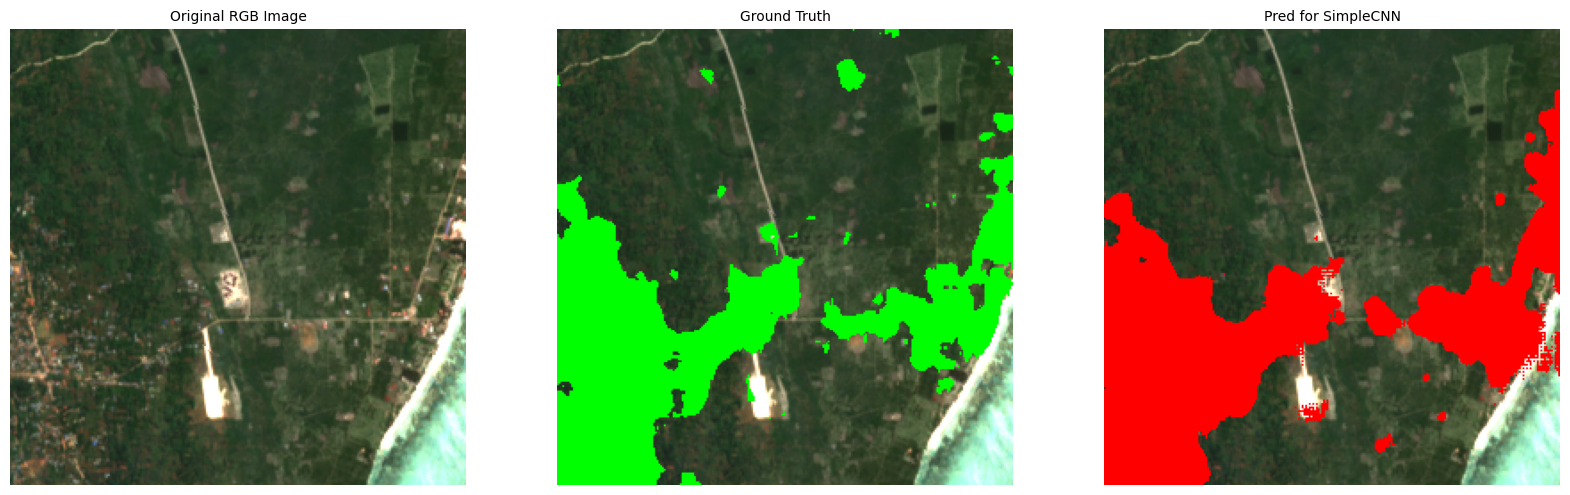

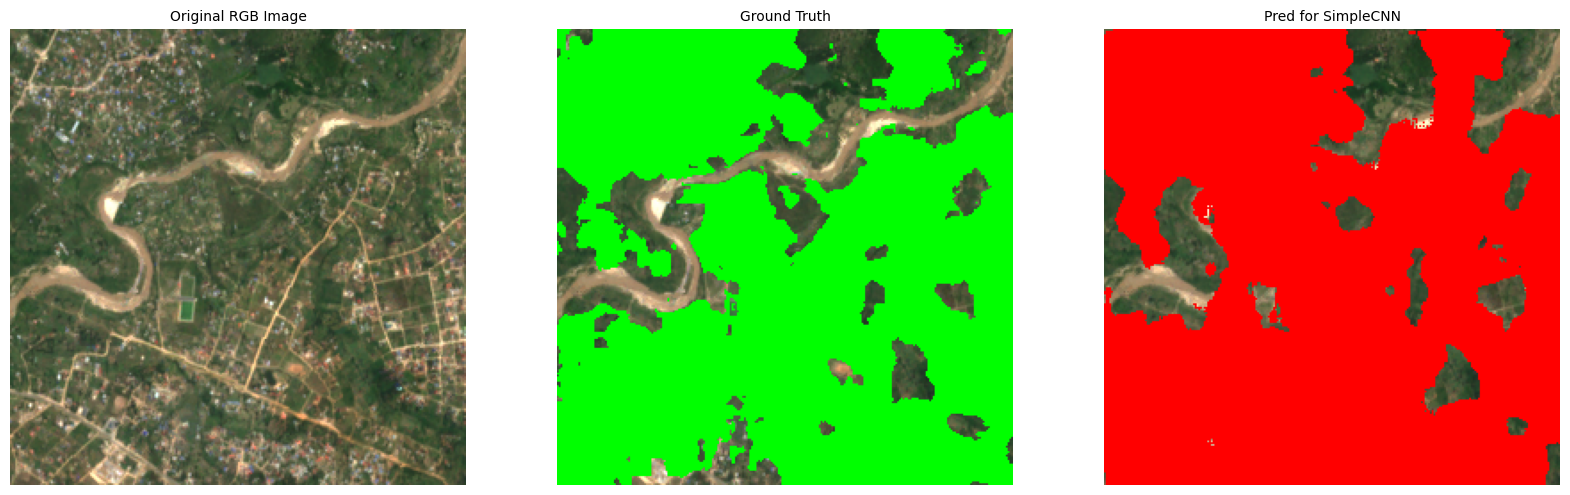

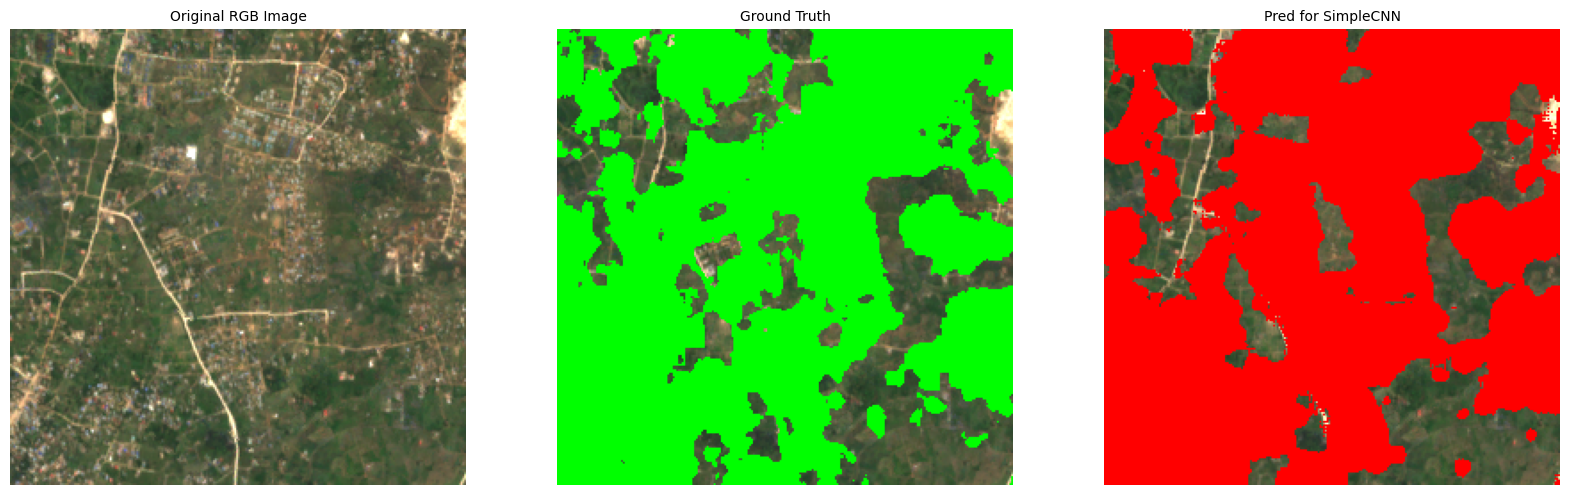

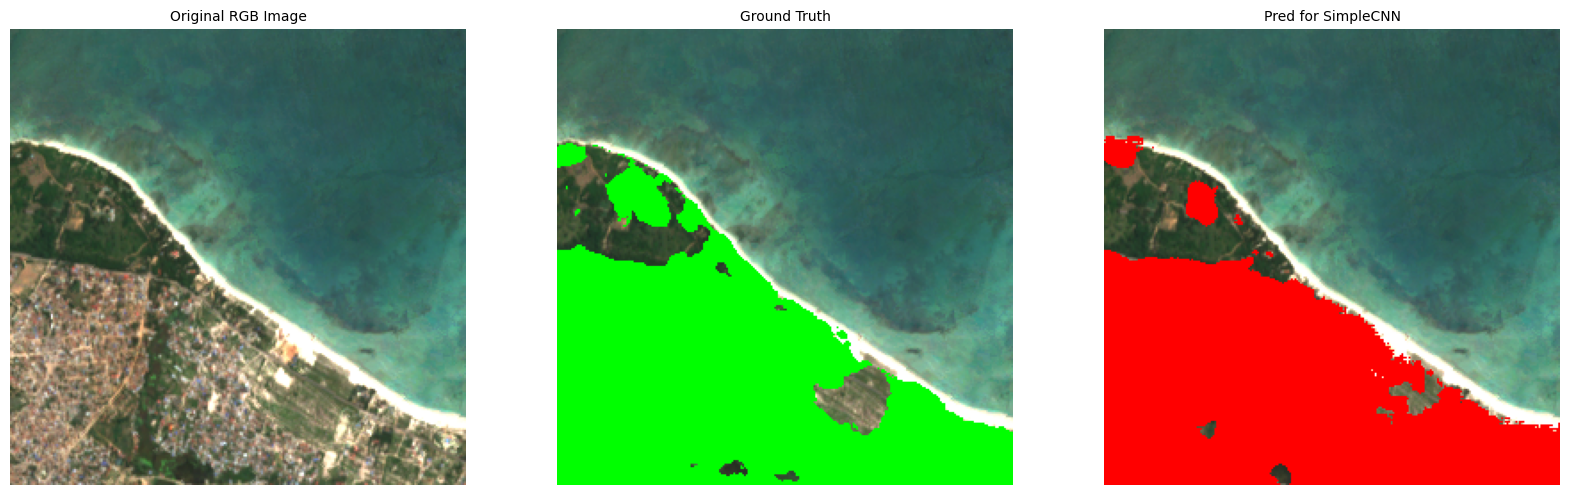

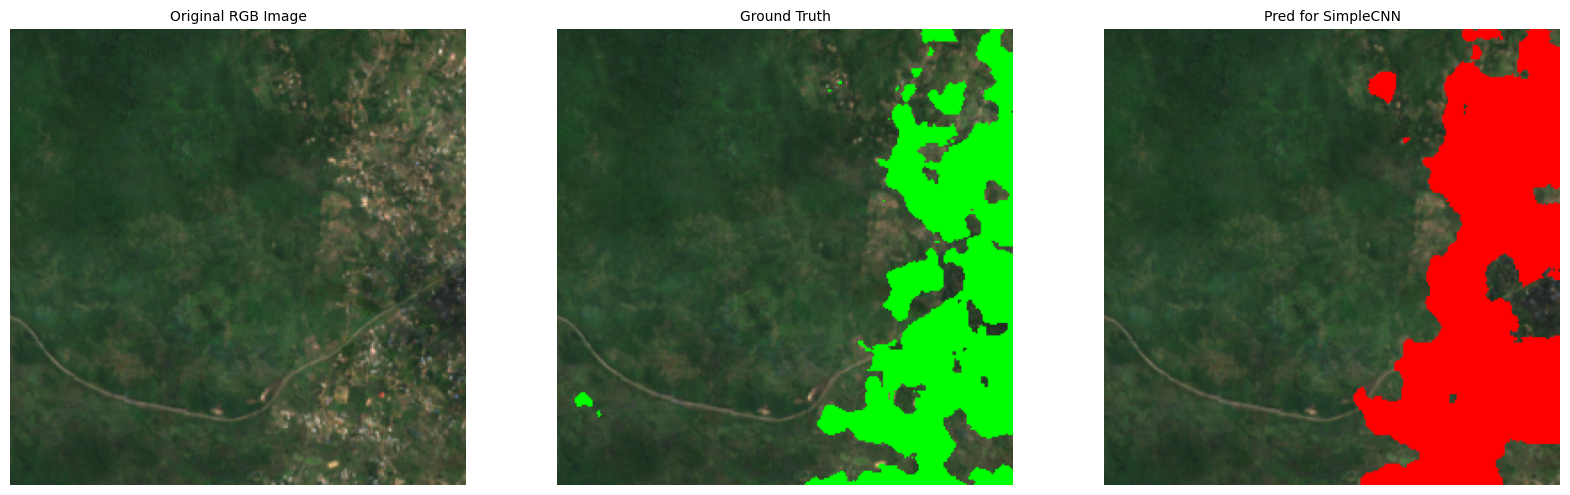

In [6]:
# Get dataset
dataset_seperated = Custom_Testing_Dataset(h5_testing_file, blt_testing_file, patch_size=(256, 256), return_rgb_nir_separately=True, relevant_threshold=0.2)
dataset_for_prediction = Custom_Testing_Dataset(h5_testing_file, blt_testing_file, patch_size=(256, 256),return_rgb_nir_separately=False, relevant_threshold=0.2)

# Plot prediction and ground truth overlayed on rgb image
for i in [1, 10, 20, 100, 170]:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()
    pred = predict_on_patch(model, dataset_for_prediction, i, device)
    truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()
    plot_with_overlays(rgb, truth, predictions=[pred], model_names = ['SimpleCNN'])